In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-13 22:15:07.360796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744571707.376274  288607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744571707.380913  288607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744571707.393154  288607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744571707.393172  288607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744571707.393174  288607 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/1000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/1000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    print(mc_results)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_5000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
39995,36.155368,28633.7,7.1,116.9,10.558204,10.558204,0.0,0.0,0.0,0.0,...,356.197567,140.6,1.666013e+08,13.5,22.344181,504.642883,1.280880e+05,1.0,244.6,Bruteforce
39996,436.989332,2014.3,5.5,62.9,16.392893,16.392893,0.0,0.0,0.0,0.0,...,3.023964,69.2,2.420115e-03,5.5,11.581493,4.276530,3.052958e+01,0.3,38.5,Bruteforce
39997,0.218856,3889.2,5.4,106.5,27.824803,27.824803,0.0,0.0,0.0,0.0,...,778.624312,686.5,1.712120e-02,5.5,29.905248,1101.141062,9.659848e+05,0.9,38.5,Bruteforce
39998,63.663335,1715.2,11.5,96.8,4.135345,4.135345,0.0,0.0,0.0,0.0,...,108.960070,109.9,1.666013e+08,13.5,19.310294,153.970479,1.187418e+04,1.0,244.6,Bruteforce
39999,28.865871,48128.0,8.2,105.4,30.624000,30.624000,0.0,0.0,0.0,0.0,...,1407.994664,831.1,1.666013e+08,13.5,35.234034,1996.814533,2.011423e+06,1.0,244.6,Bruteforce


In [7]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [8]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [9]:
y

0              DDoS
1              DDoS
2              DDoS
3              DDoS
4              DDoS
            ...    
39995    Bruteforce
39996    Bruteforce
39997    Bruteforce
39998    Bruteforce
39999    Bruteforce
Name: Attack Type, Length: 40000, dtype: object

In [10]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [13]:
results_dict = {}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34000, 46), (34000,), (6000, 46), (6000,))

# K Nearest Neighbour

In [15]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 1.05 s, sys: 4.87 ms, total: 1.06 s
Wall time: 292 ms


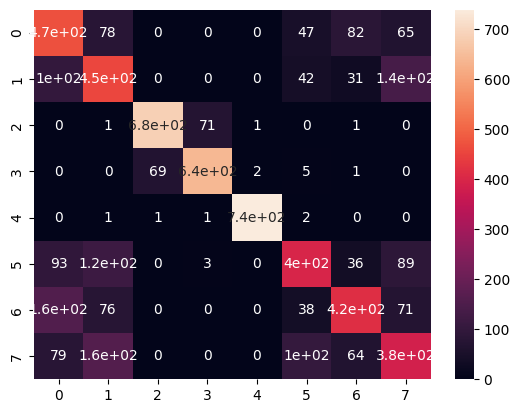

In [16]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [19]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [20]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.6965,0.701881,0.697061,0.6965,0.653815,1.171667,6.063667,2.462451,0.292083


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.632928    0.594241  0.902375  0.892308  0.993271  0.538776   
recall     0.522854    0.511838  0.907162  0.894811  0.995951  0.627575   
f1-score   0.572650    0.549970  0.904762  0.893557  0.994609  0.579795   

           Spoofing       Web  
precision  0.548942  0.488579  
recall     0.658730  0.515395  
f1-score   0.598846  0.501629  


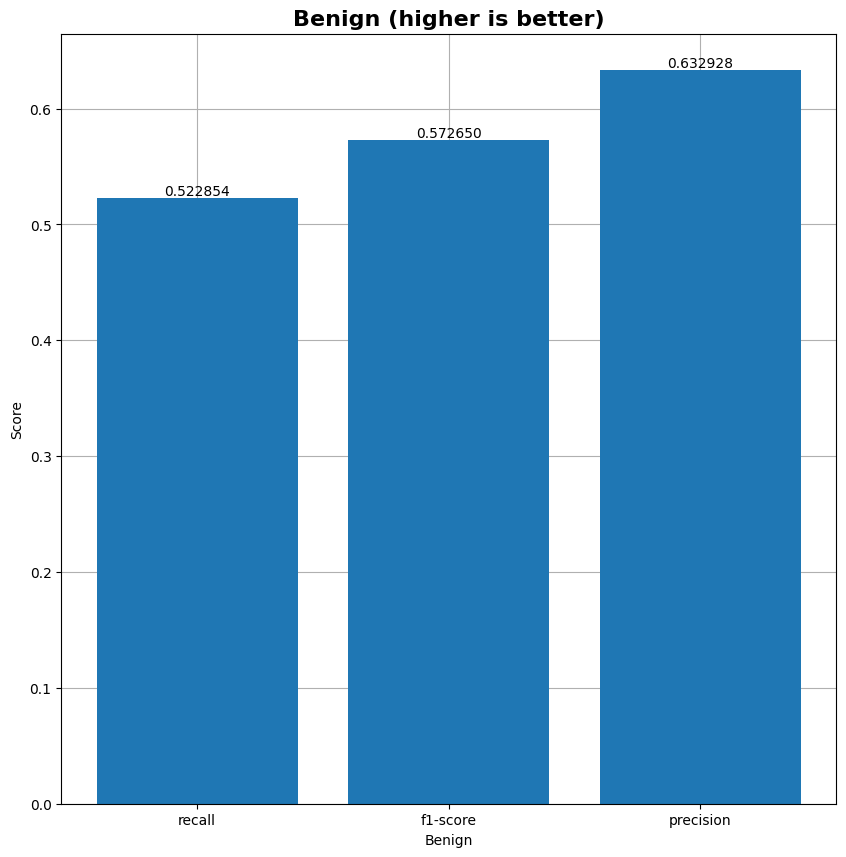

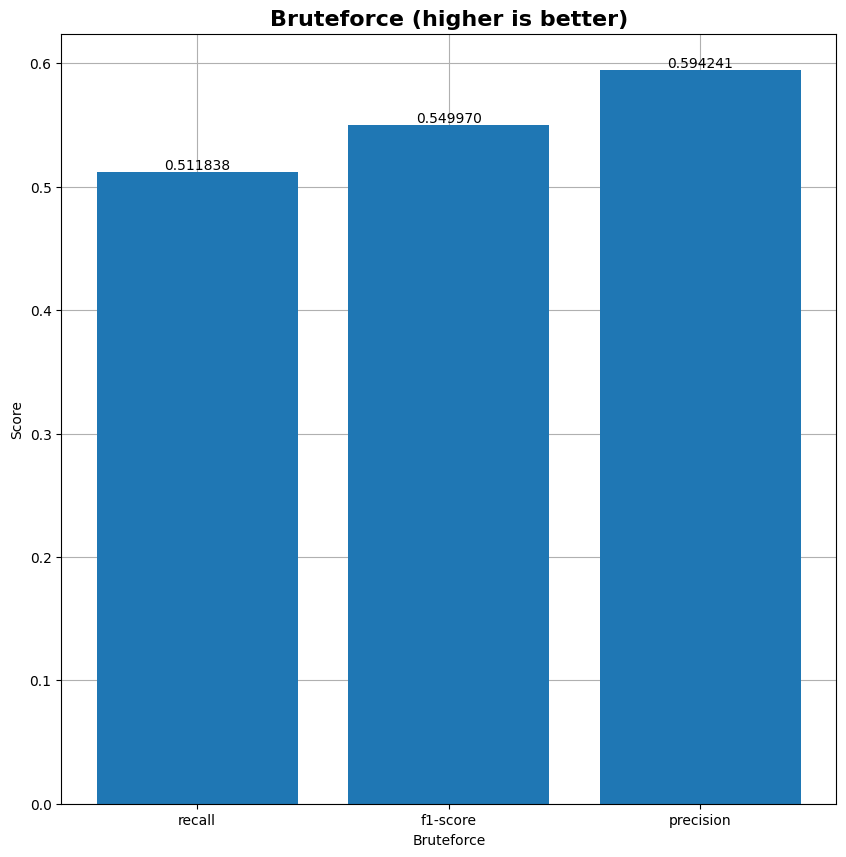

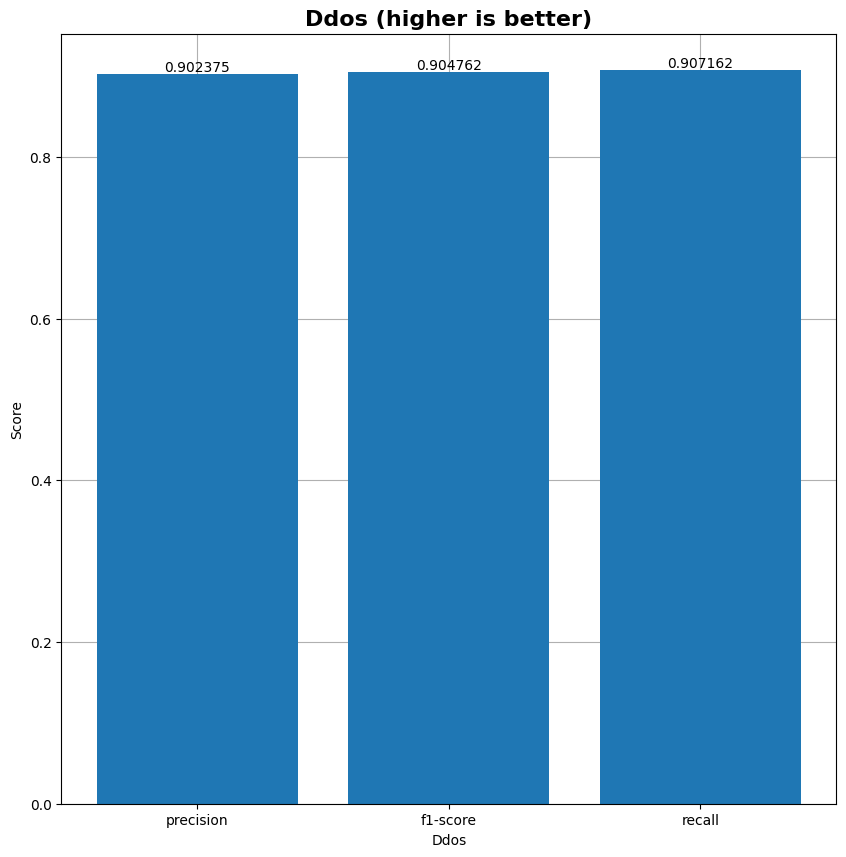

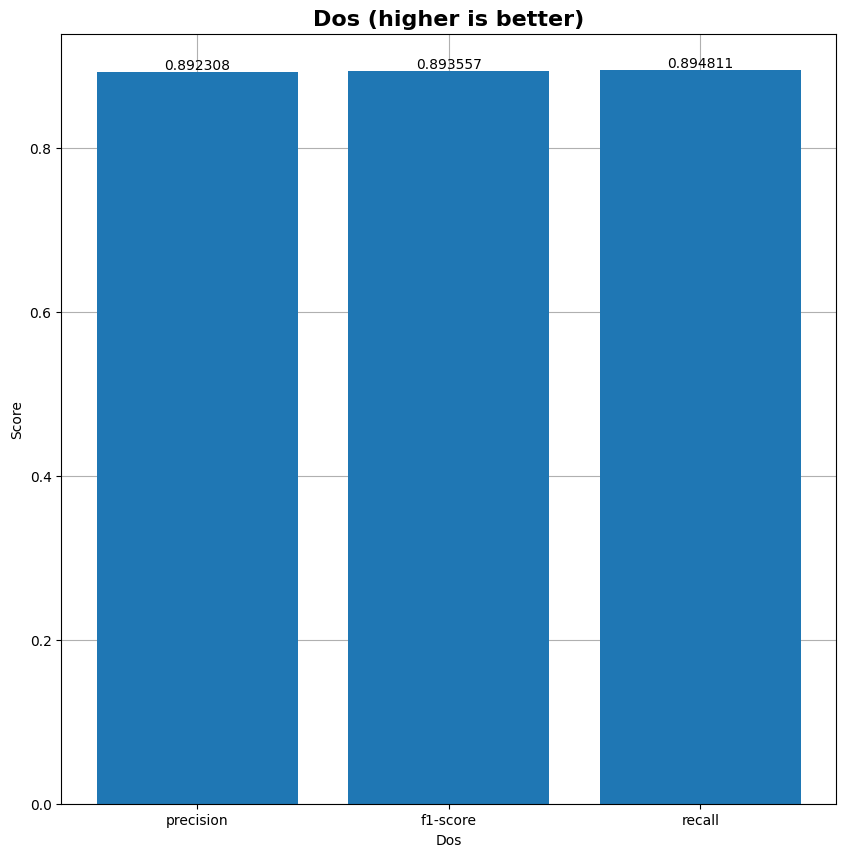

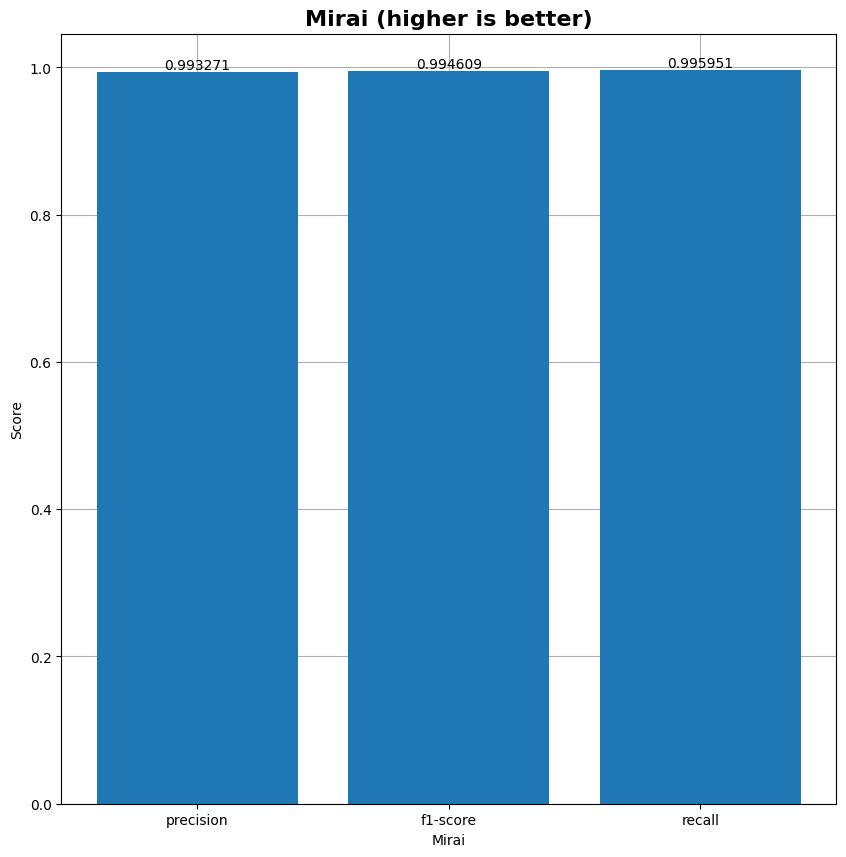

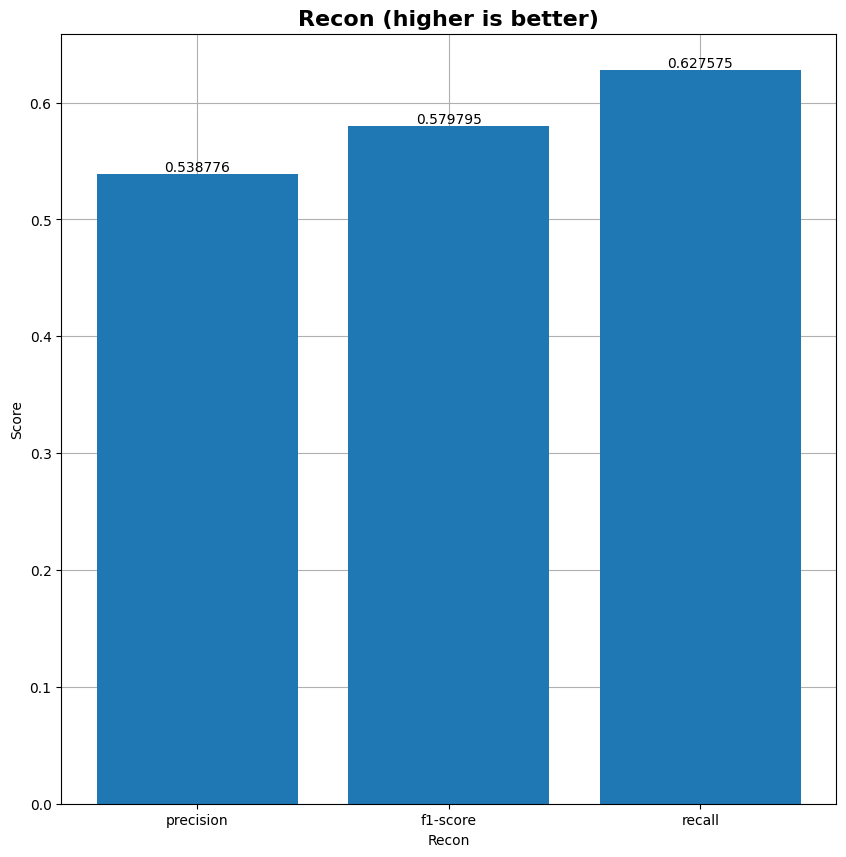

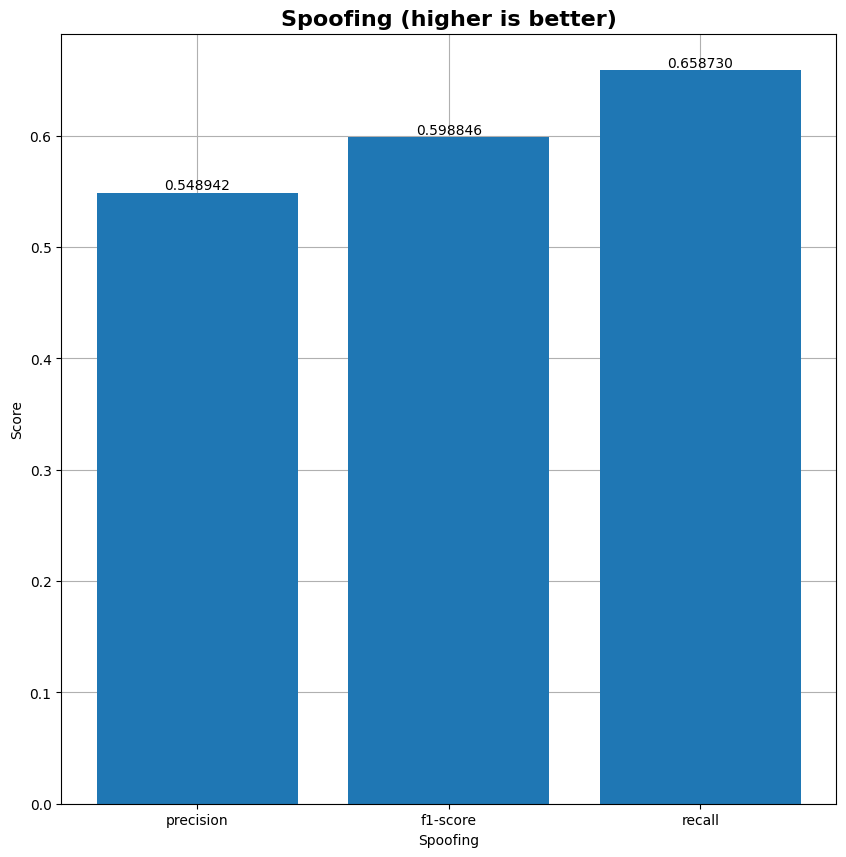

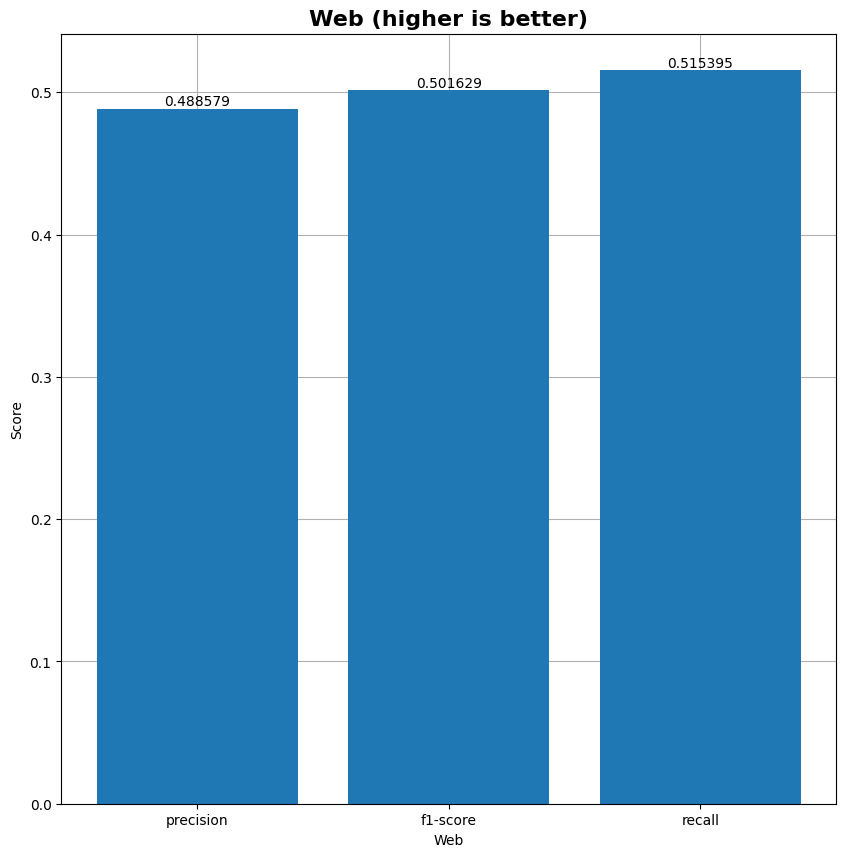

In [21]:
plot_mc(y_pred, y_test, "kNN")

In [22]:
model_name = "kNN_5000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [23]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

CPU times: user 2min 5s, sys: 109 ms, total: 2min 5s
Wall time: 2min 6s


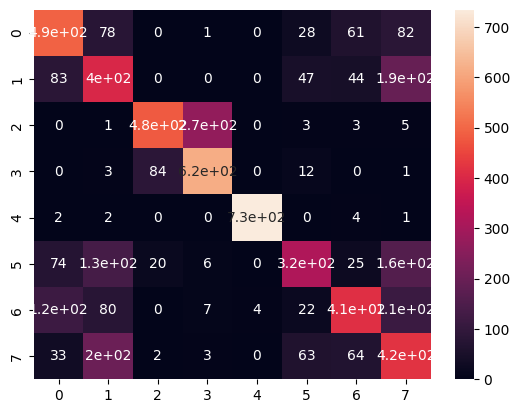

In [24]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [25]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [26]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [27]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [28]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.662618    0.519634  0.631926  0.860140  0.987887  0.432653   
recall     0.614518    0.442586  0.818803  0.684093  0.994580  0.645030   
f1-score   0.637662    0.478025  0.713328  0.762082  0.991222  0.517915   

           Spoofing       Web  
precision  0.547619  0.534264  
recall     0.673171  0.432238  
f1-score   0.603939  0.477866  


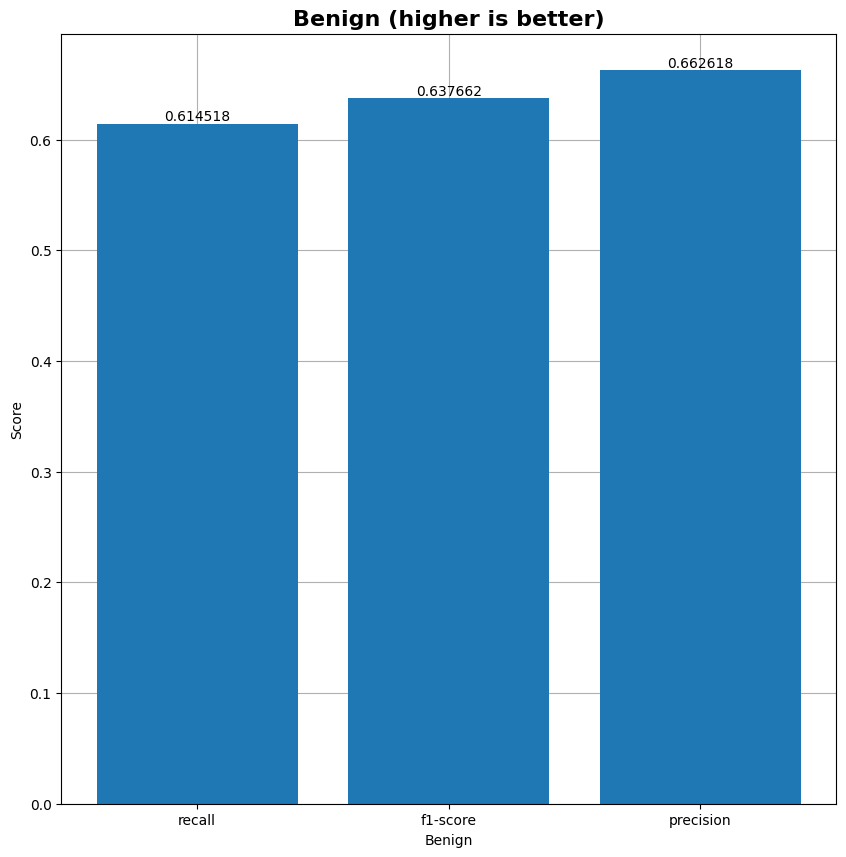

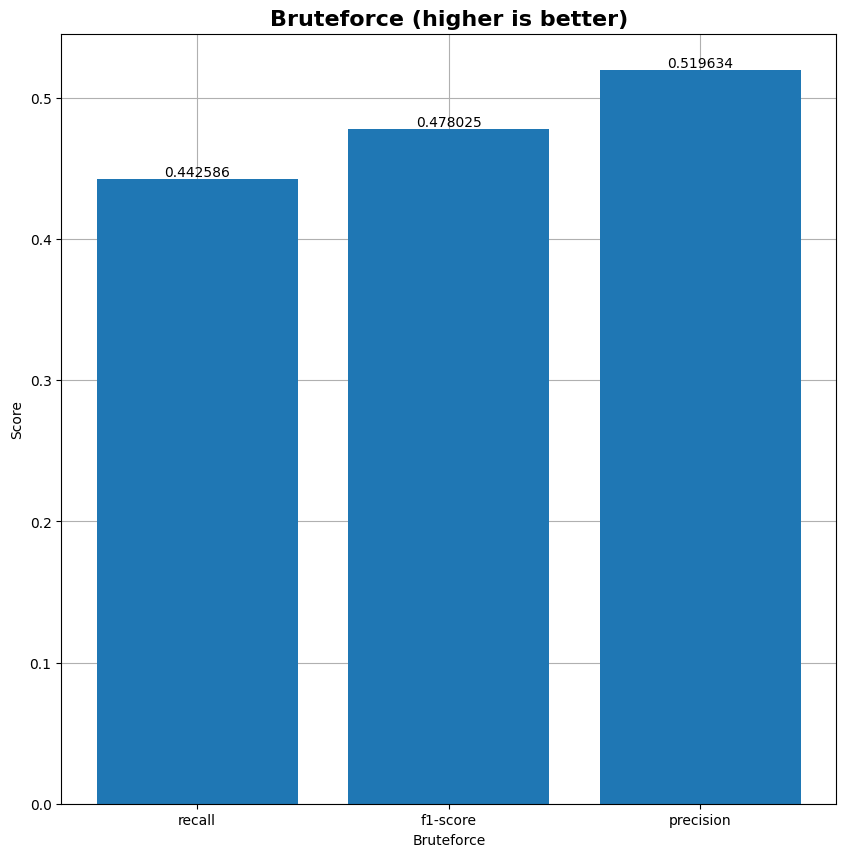

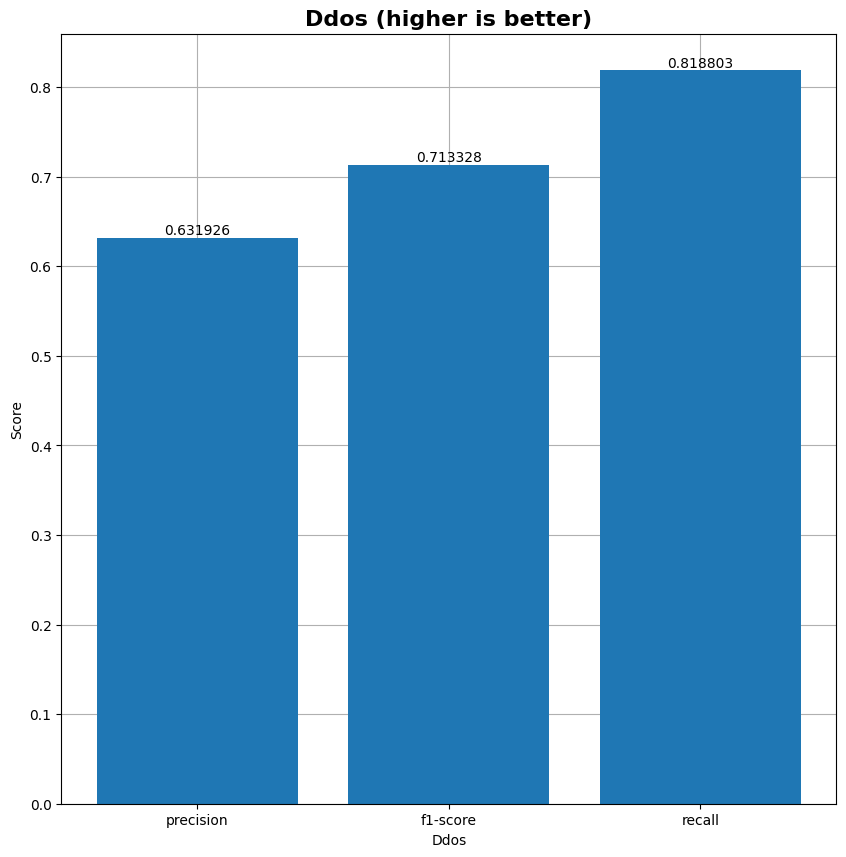

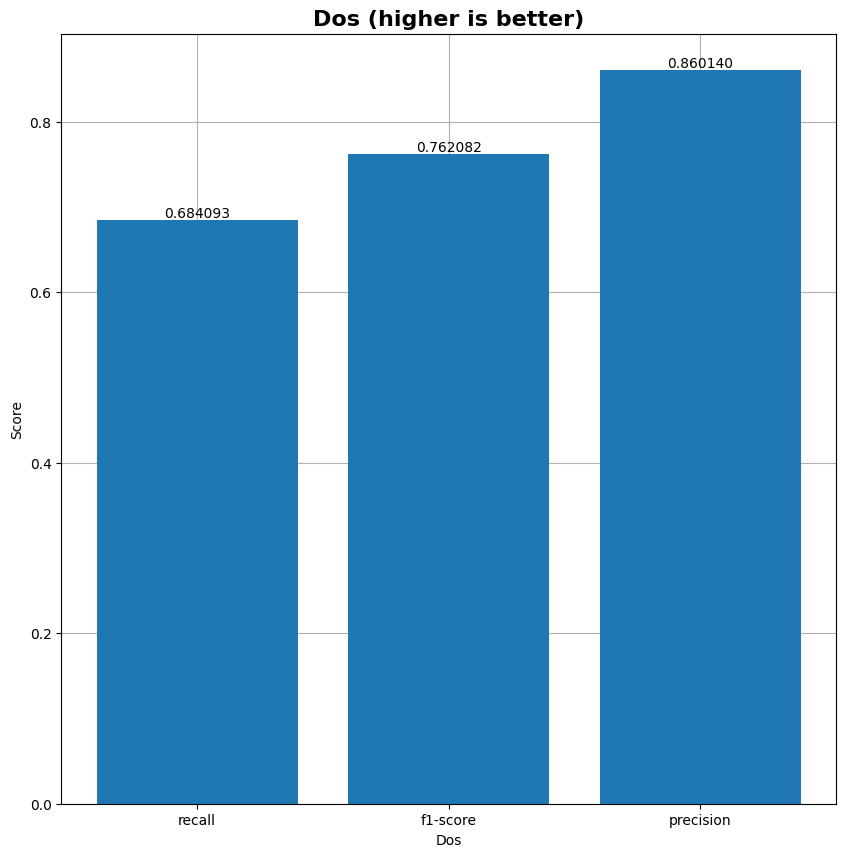

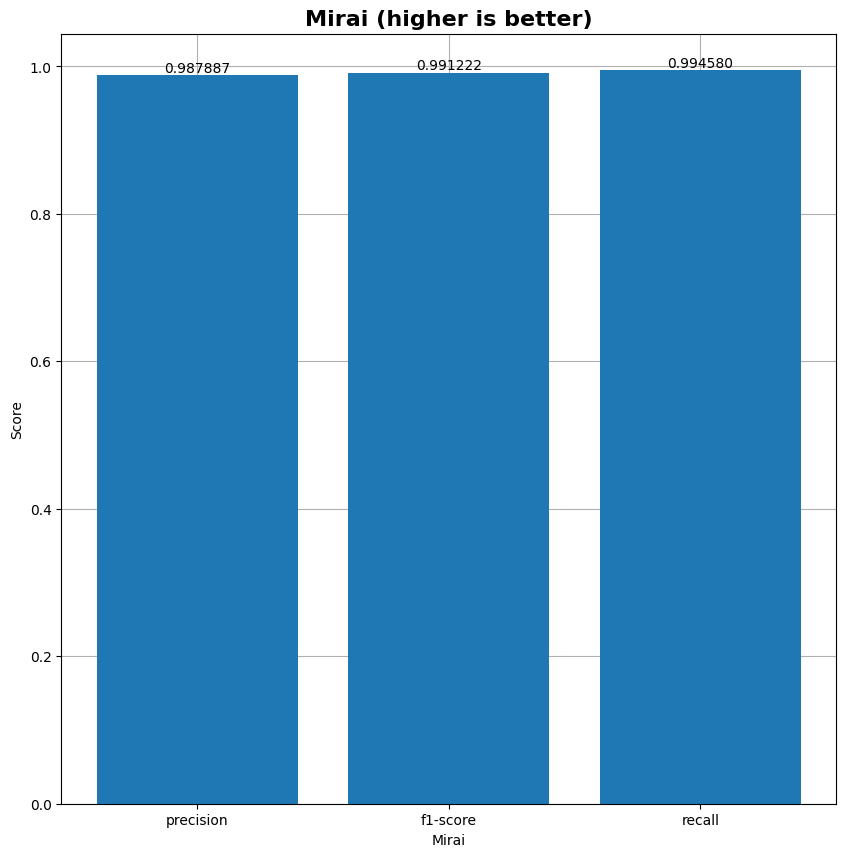

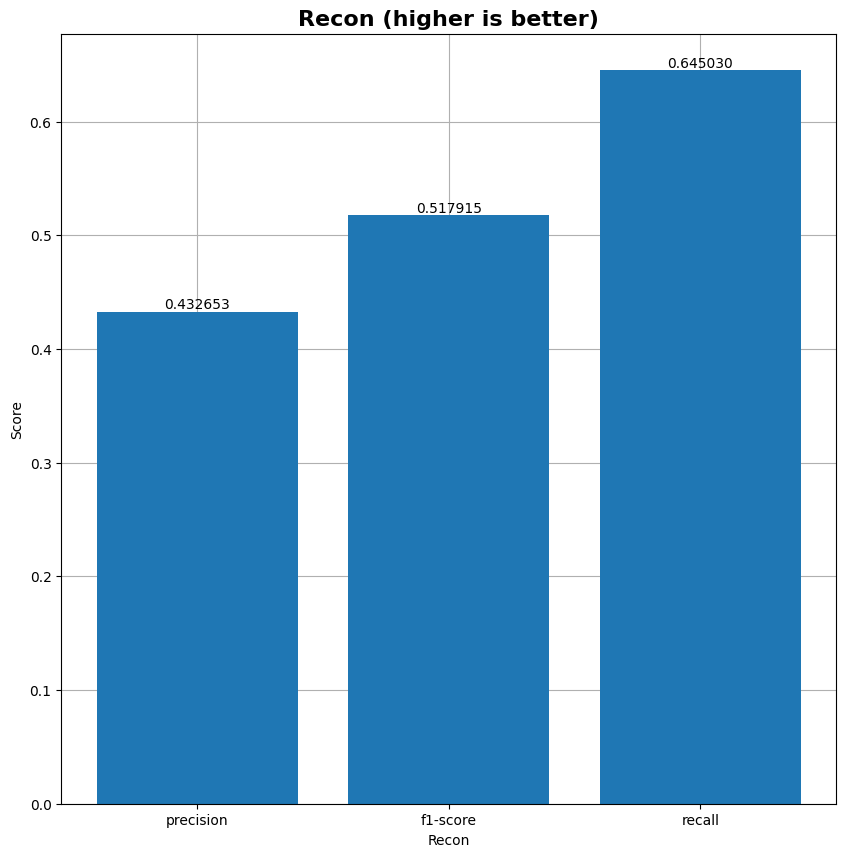

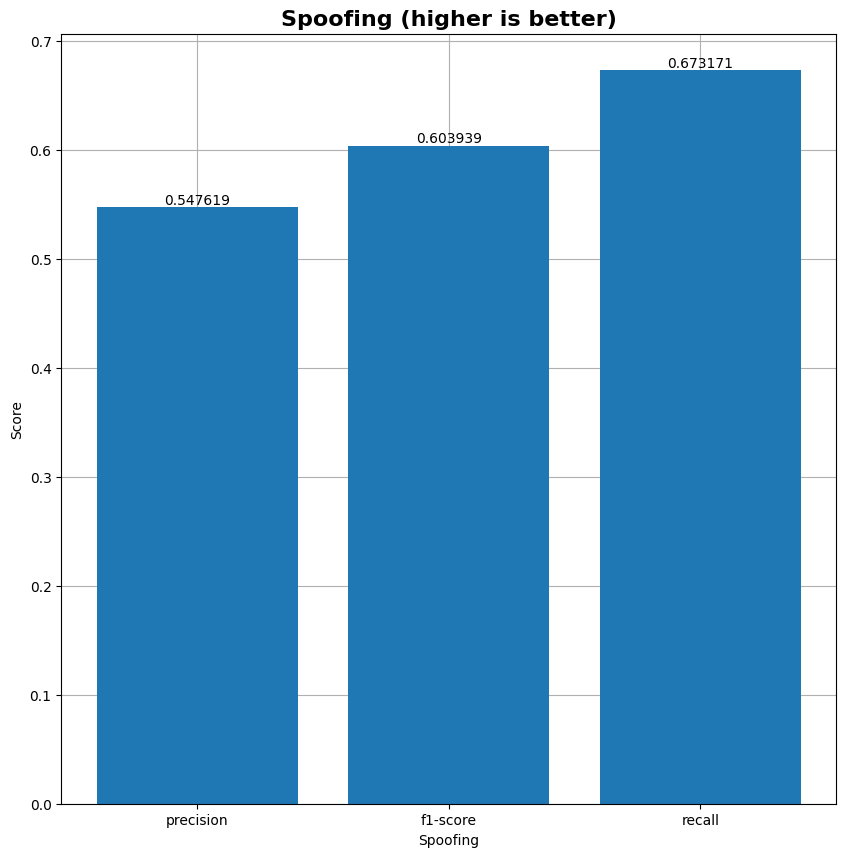

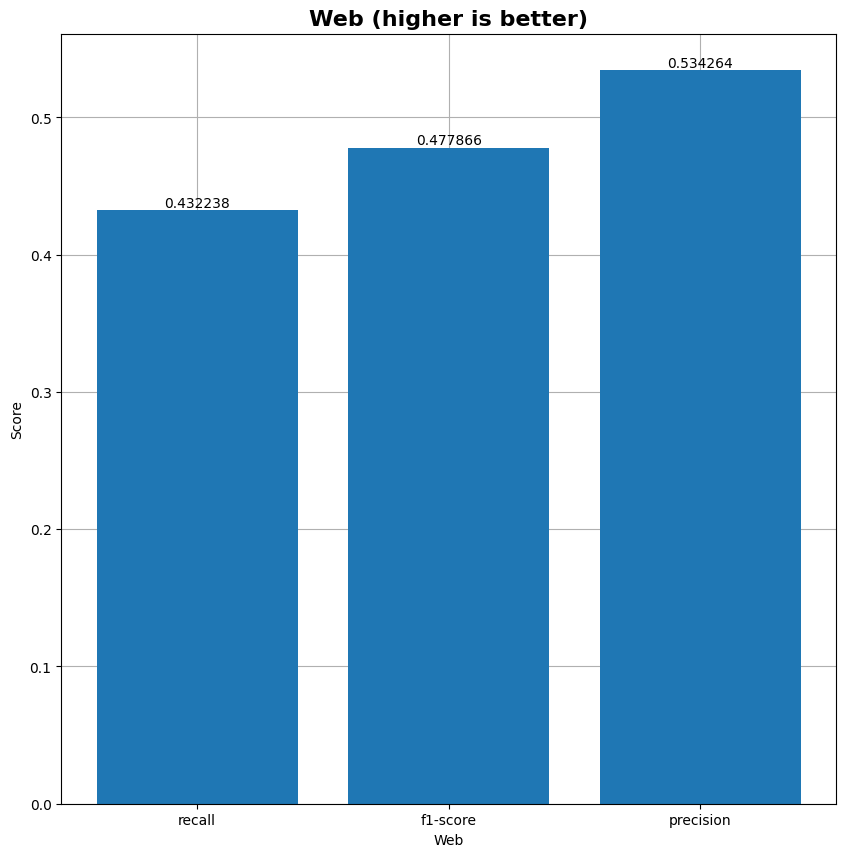

In [29]:
plot_mc(y_pred, y_test, "LR")

In [30]:
model_name = "LR_5000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [31]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 11.5 s, sys: 94.2 ms, total: 11.6 s
Wall time: 1.61 s


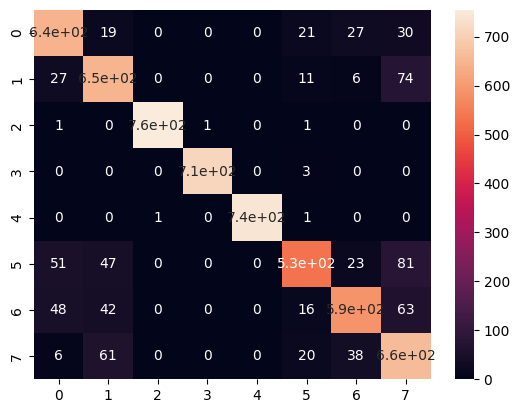

In [32]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [33]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [34]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [35]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [36]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.869096    0.845550  0.996042  0.995804  0.997308  0.725170   
recall     0.828829    0.792638  0.998677  0.998597  1.000000  0.879538   
f1-score   0.848485    0.818239  0.997358  0.997199  0.998652  0.794929   

           Spoofing       Web  
precision  0.776455  0.841371  
recall     0.861968  0.727772  
f1-score   0.816980  0.780459  


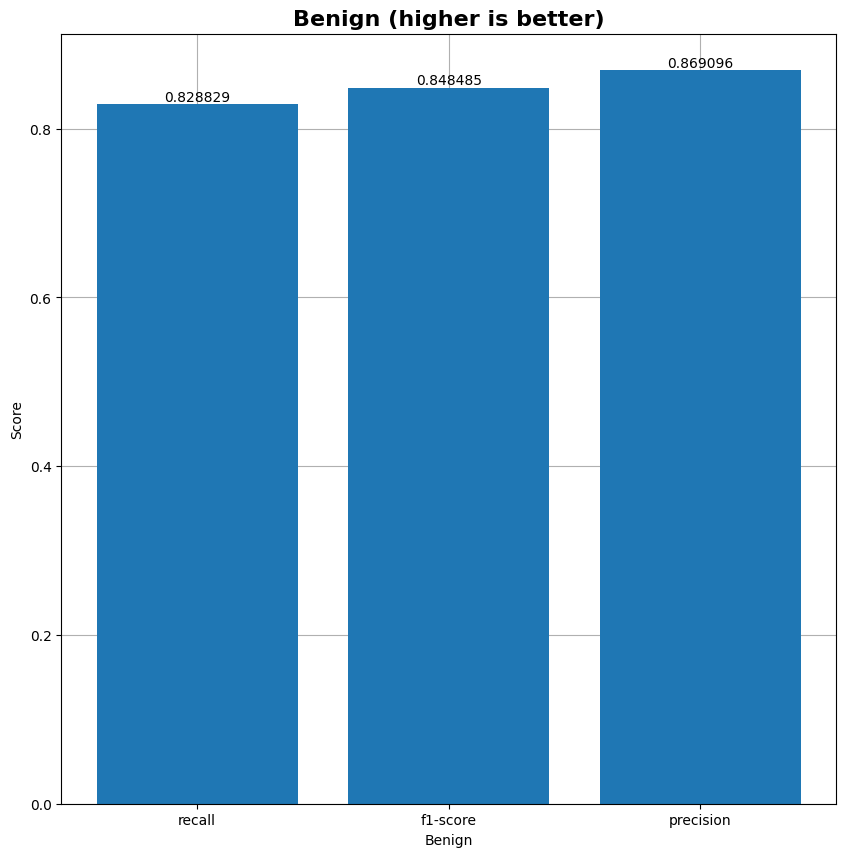

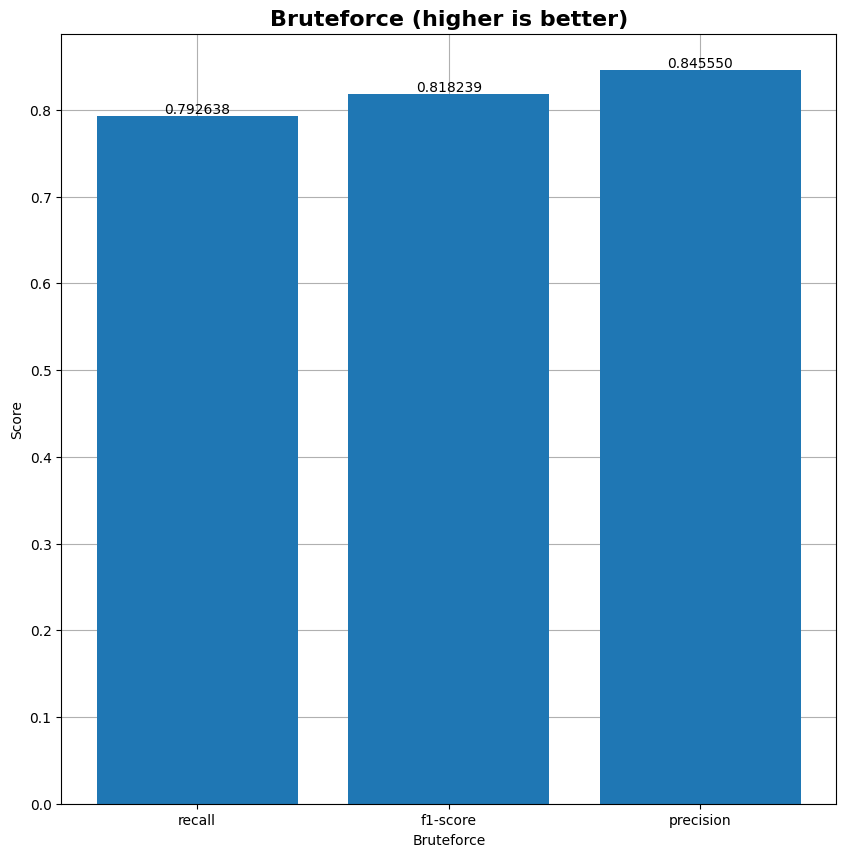

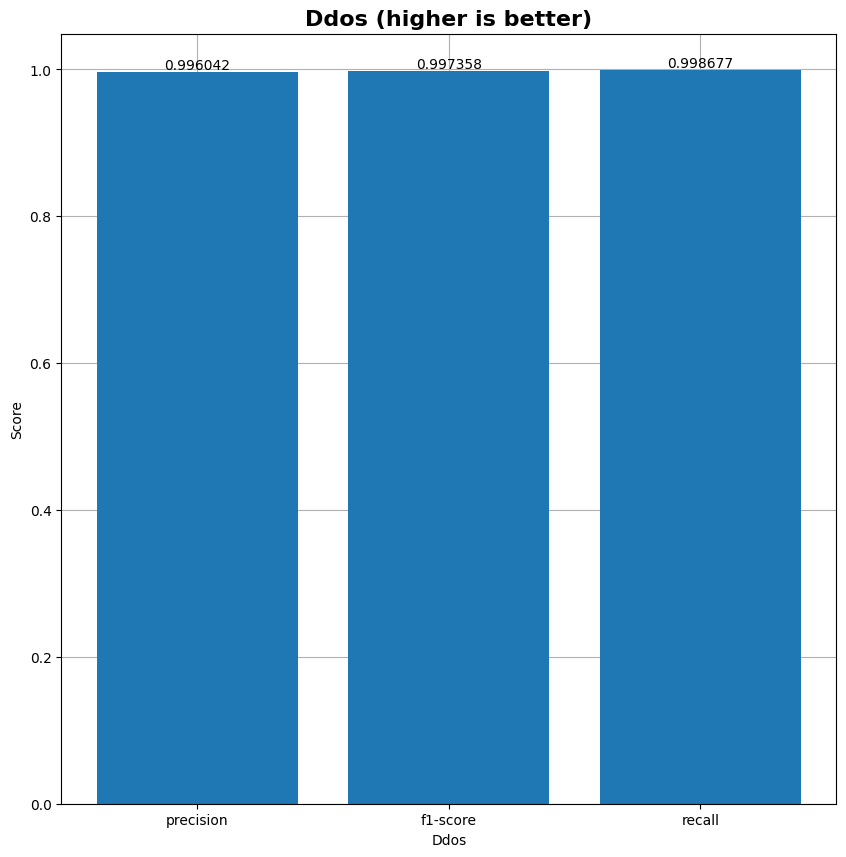

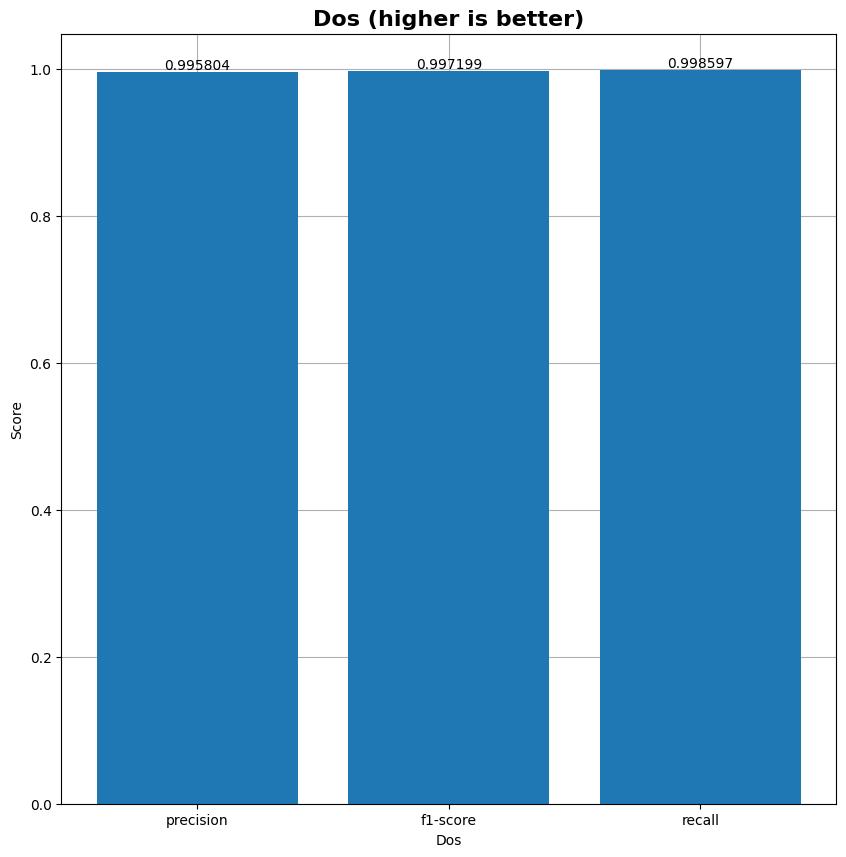

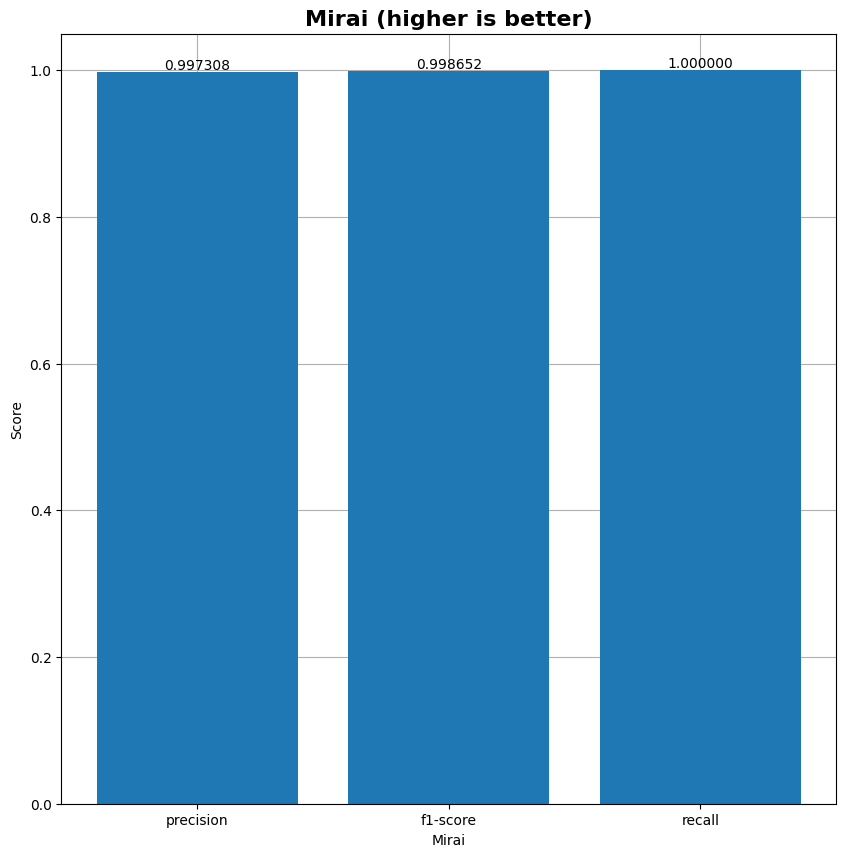

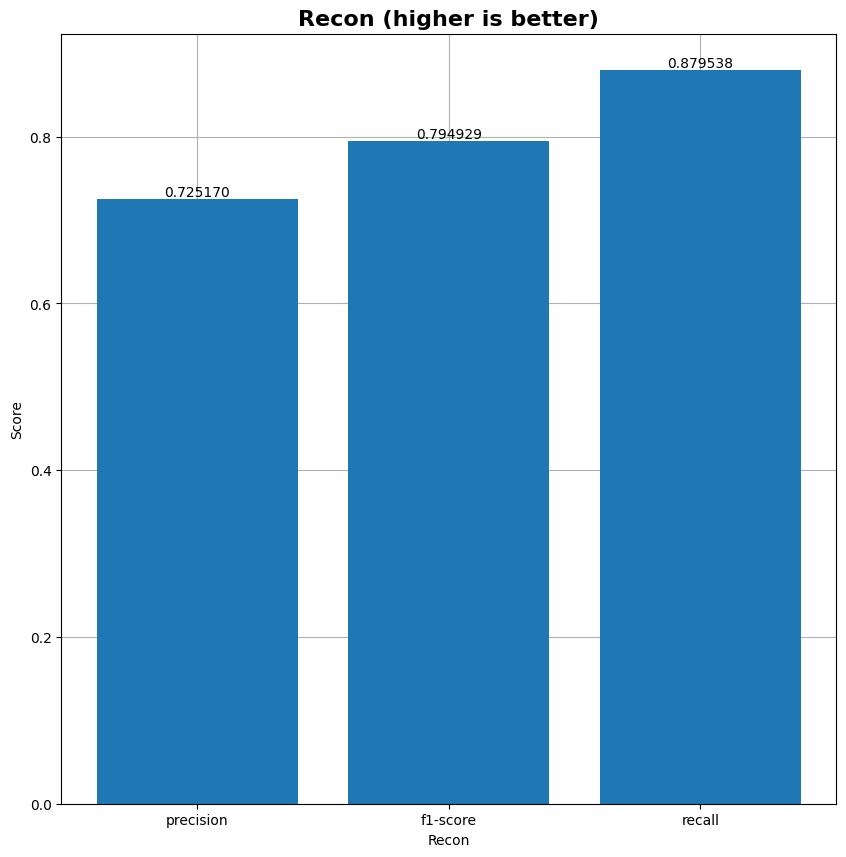

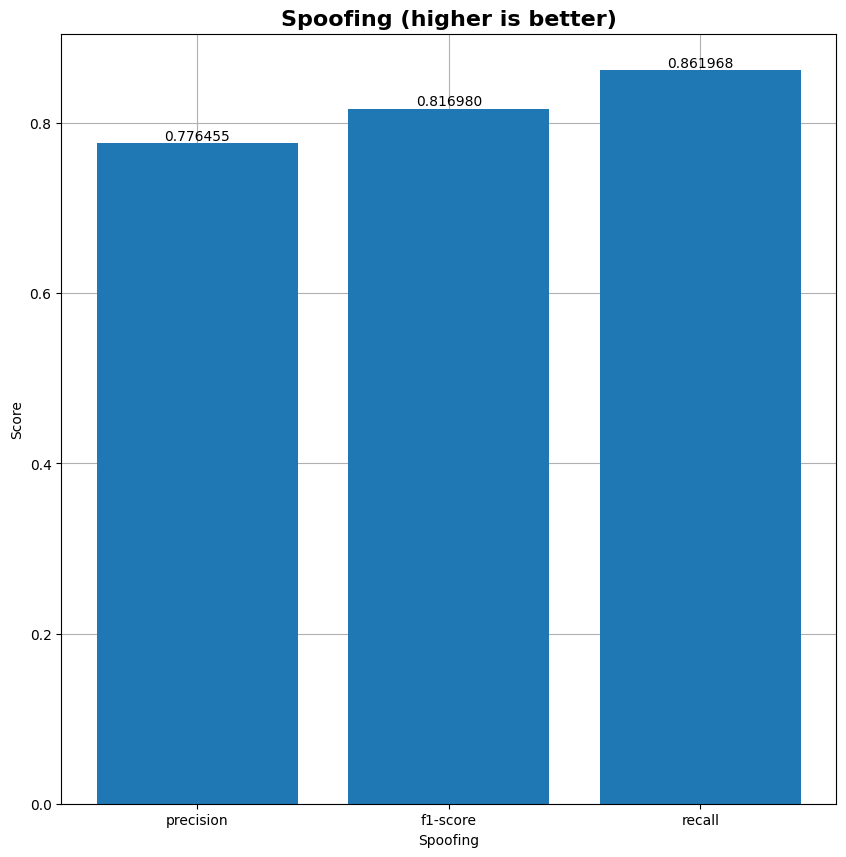

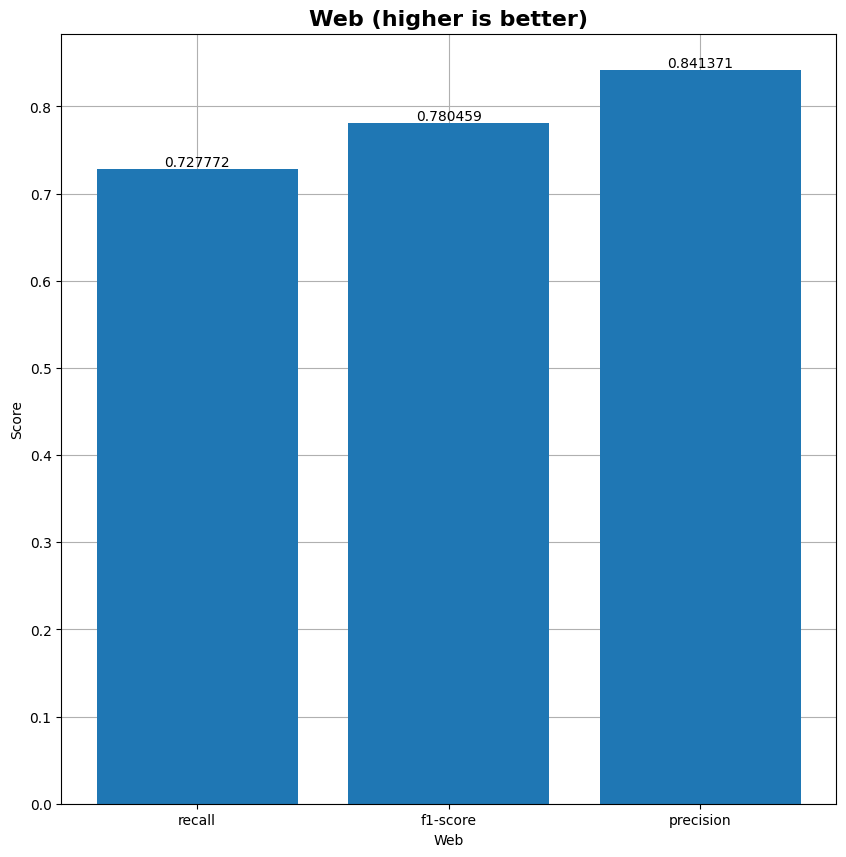

In [37]:
plot_mc(y_pred, y_test, "RF")

In [38]:
model_name = "RF_5000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [39]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 14.2 s, sys: 117 ms, total: 14.4 s
Wall time: 1.93 s


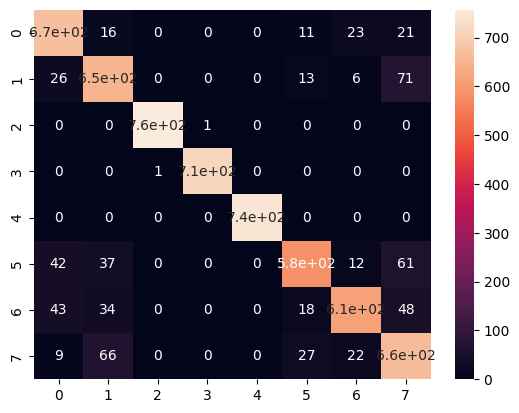

In [40]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [41]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [42]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [43]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [44]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305
XGBoost,0.898667,0.901361,0.898907,0.898667,0.884487,0.402167,2.066500,1.437533,1.928581


             Benign  Bruteforce      DDoS       DoS  Mirai     Recon  \
precision  0.904184    0.848168  0.998681  0.998601    1.0  0.793197   
recall     0.848101    0.808989  0.998681  0.998601    1.0  0.894172   
f1-score   0.875245    0.828115  0.998681  0.998601    1.0  0.840663   

           Spoofing       Web  
precision  0.810847  0.842640  
recall     0.906805  0.767630  
f1-score   0.856145  0.803388  


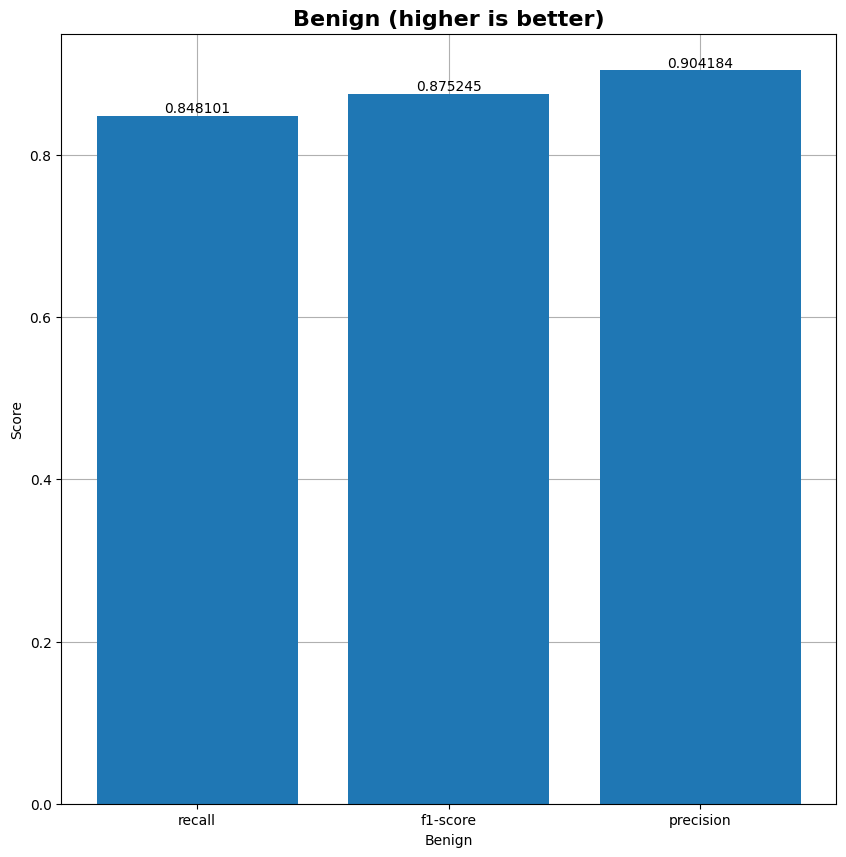

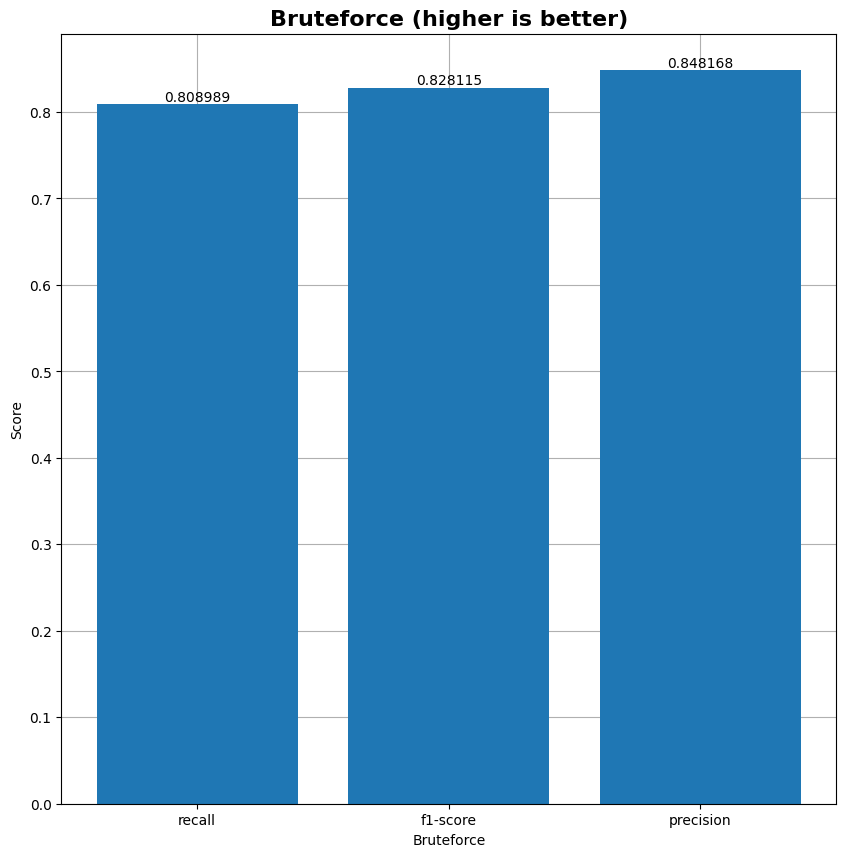

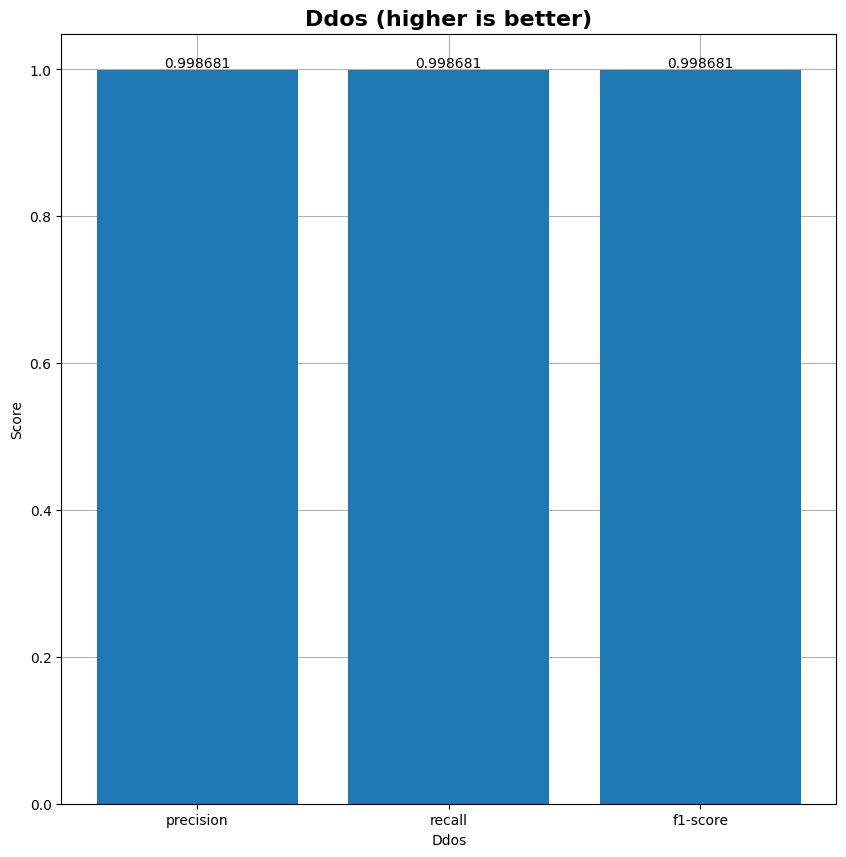

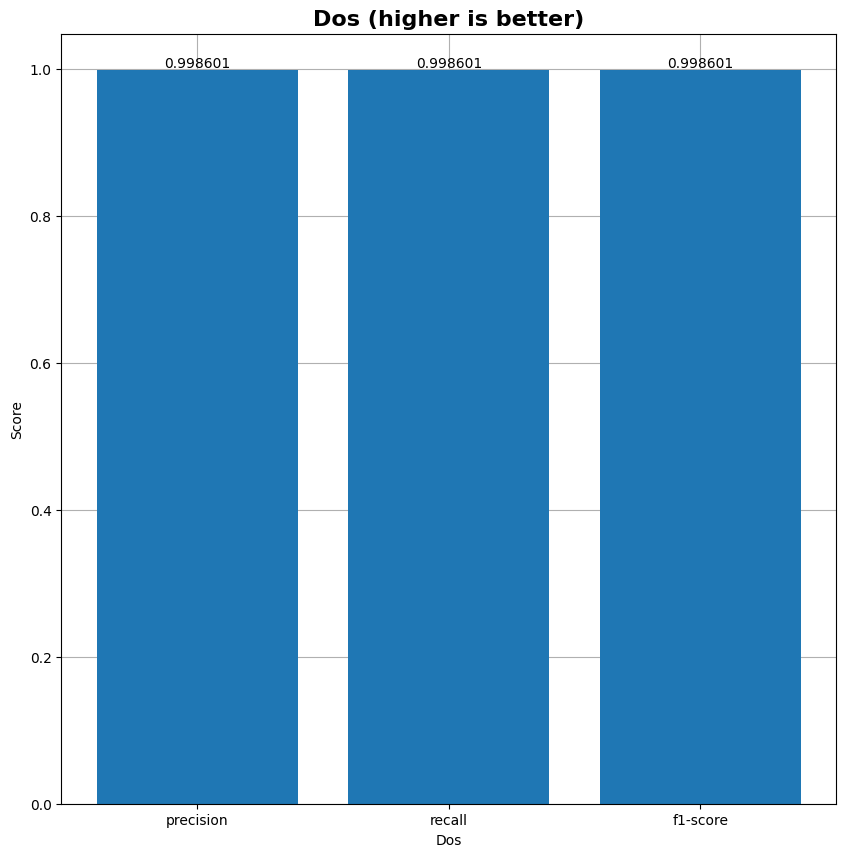

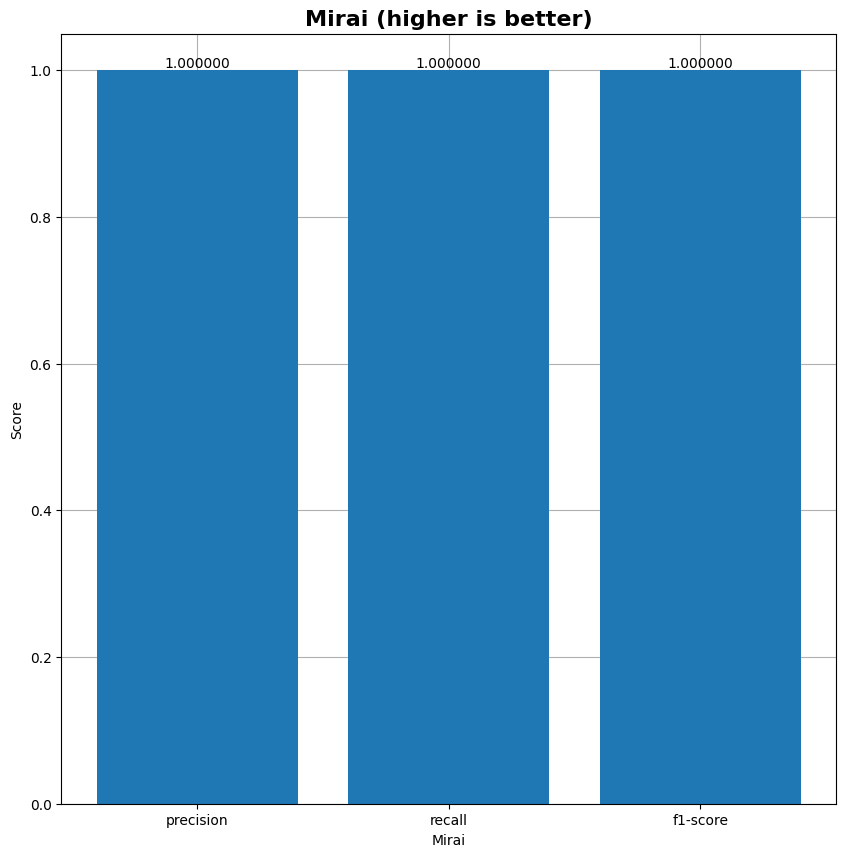

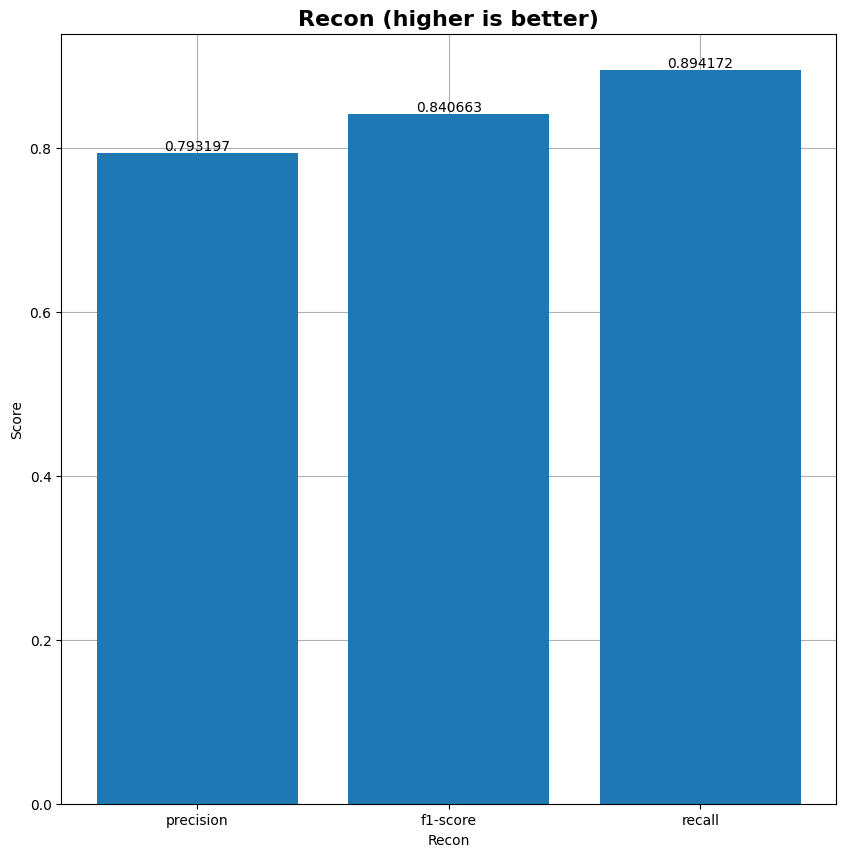

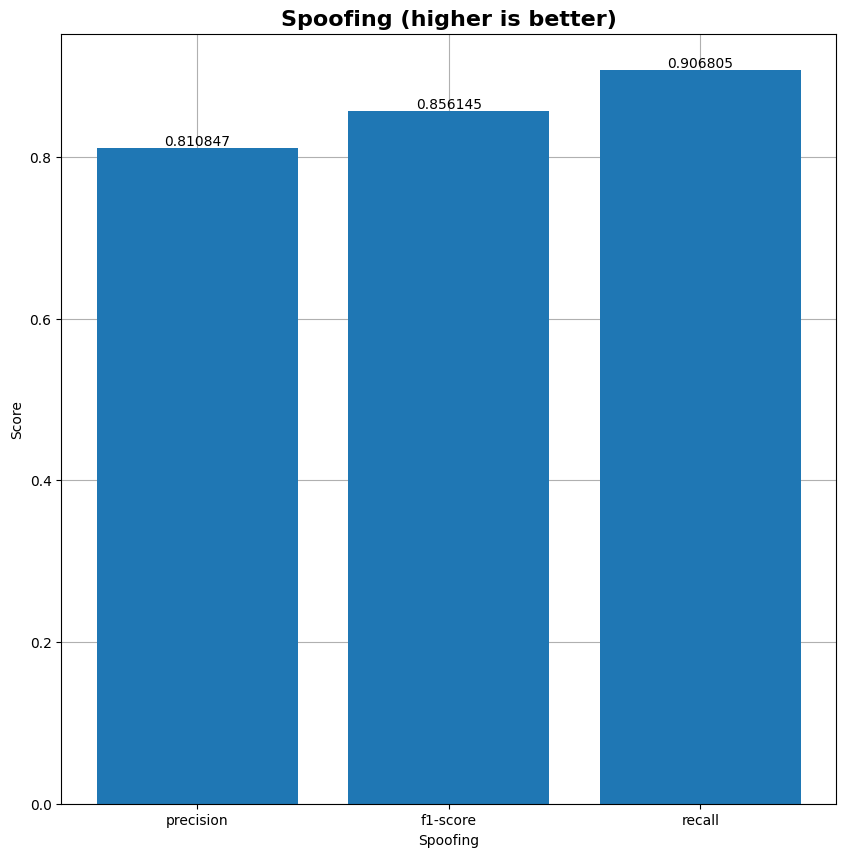

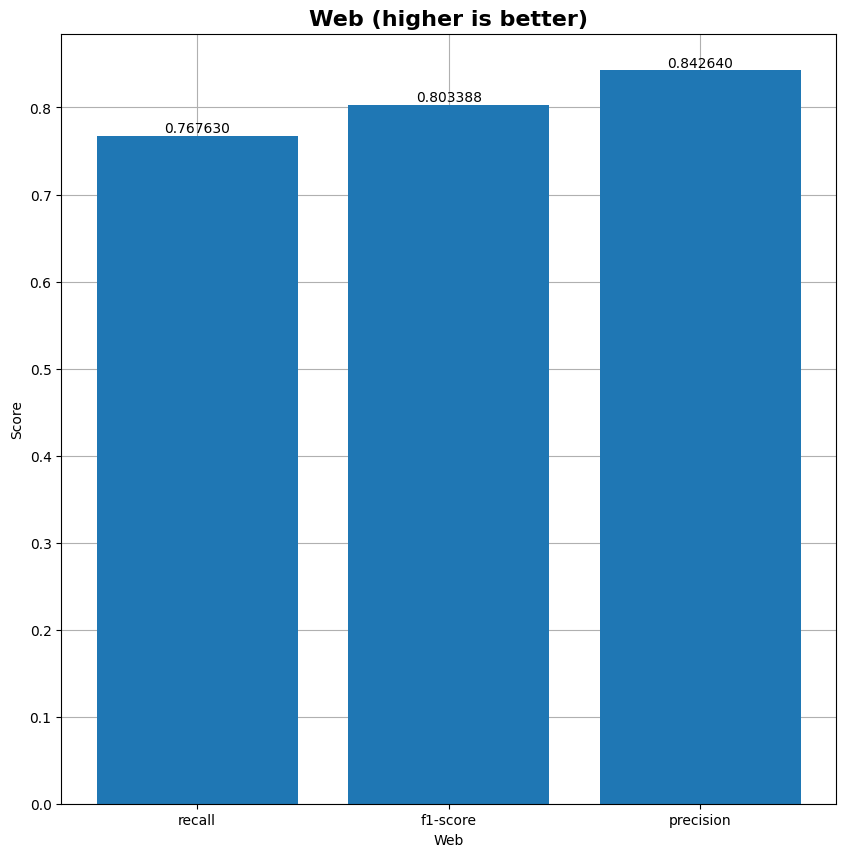

In [45]:
plot_mc(y_pred, y_test, "XGBoost")

In [46]:
model_name = "XGB_5000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [47]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5108
[LightGBM] [Info] Number of data points in the train set: 34000, number of used features: 39
[LightGBM] [Info] Start training from score -2.077326
[LightGBM] [Info] Start training from score -2.082741
[LightGBM] [Info] Start training from score -2.081326
[LightGBM] [Info] Start training from score -2.071240
[LightGBM] [Info] Start training from score -2.077796
[LightGBM] [Info] Start training from score -2.075918
[LightGBM] [Info] Start training from score -2.080854
[LightGBM] [Info] Start training from score -2.088423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 6.62 s, sys: 72.6 ms, total: 6.69 s
Wall time: 1.69 s


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


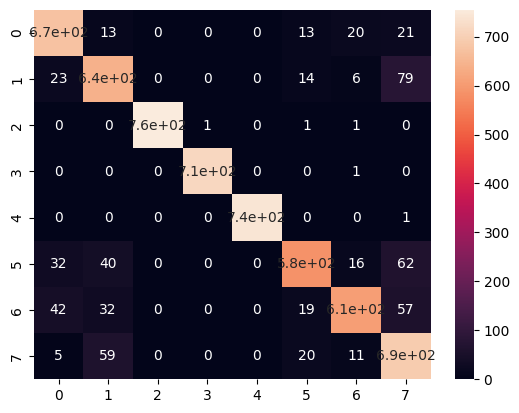

In [48]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [49]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [50]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [51]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [52]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305
XGBoost,0.898667,0.901361,0.898907,0.898667,0.884487,0.402167,2.066500,1.437533,1.928581
LightGBM,0.901833,0.905553,0.902174,0.901833,0.888248,0.388333,1.987333,1.409728,1.693437


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.909582    0.840314  0.996042  0.998601  0.998654  0.795918   
recall     0.868557    0.816794  1.000000  0.998601  1.000000  0.897239   
f1-score   0.888596    0.828387  0.998017  0.998601  0.999327  0.843547   

           Spoofing       Web  
precision  0.801587  0.879442  
recall     0.916793  0.759036  
f1-score   0.855328  0.814815  


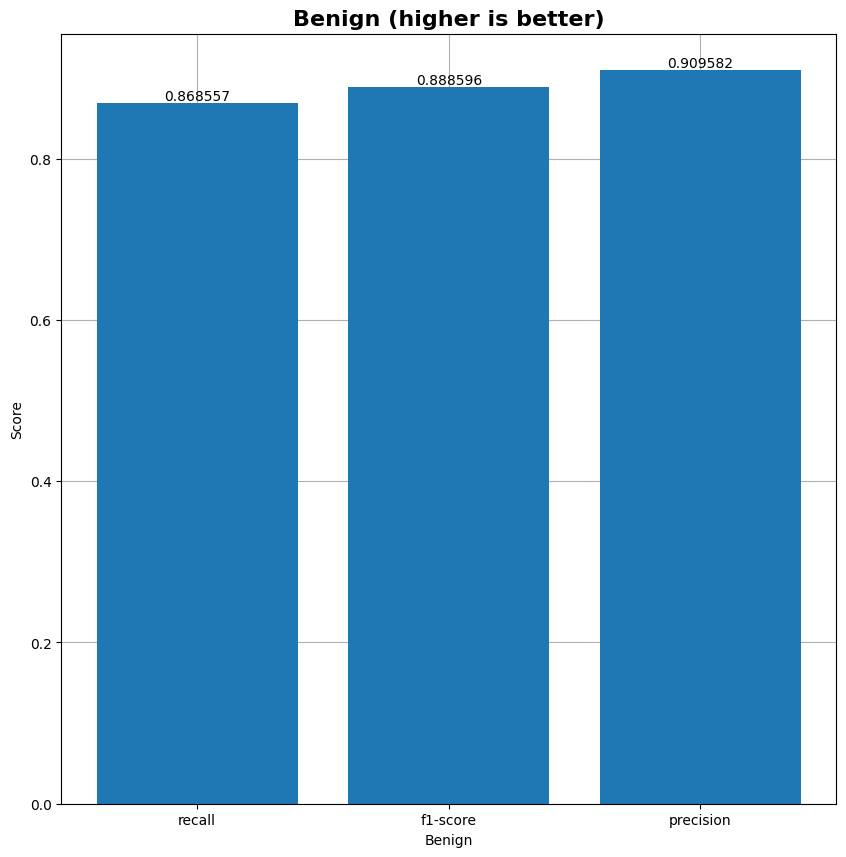

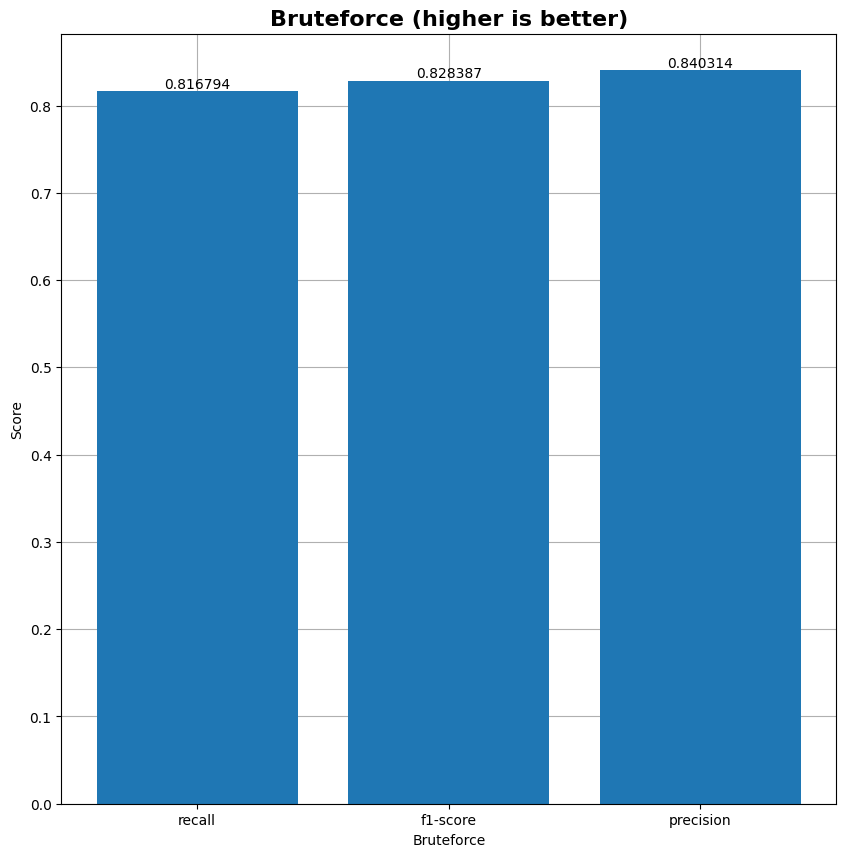

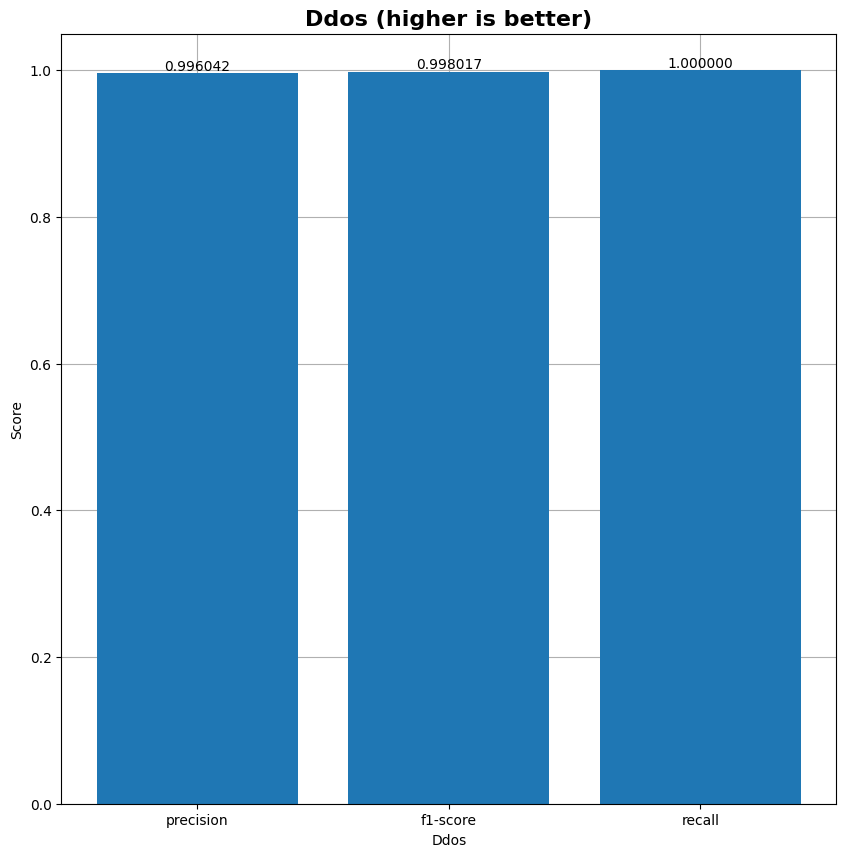

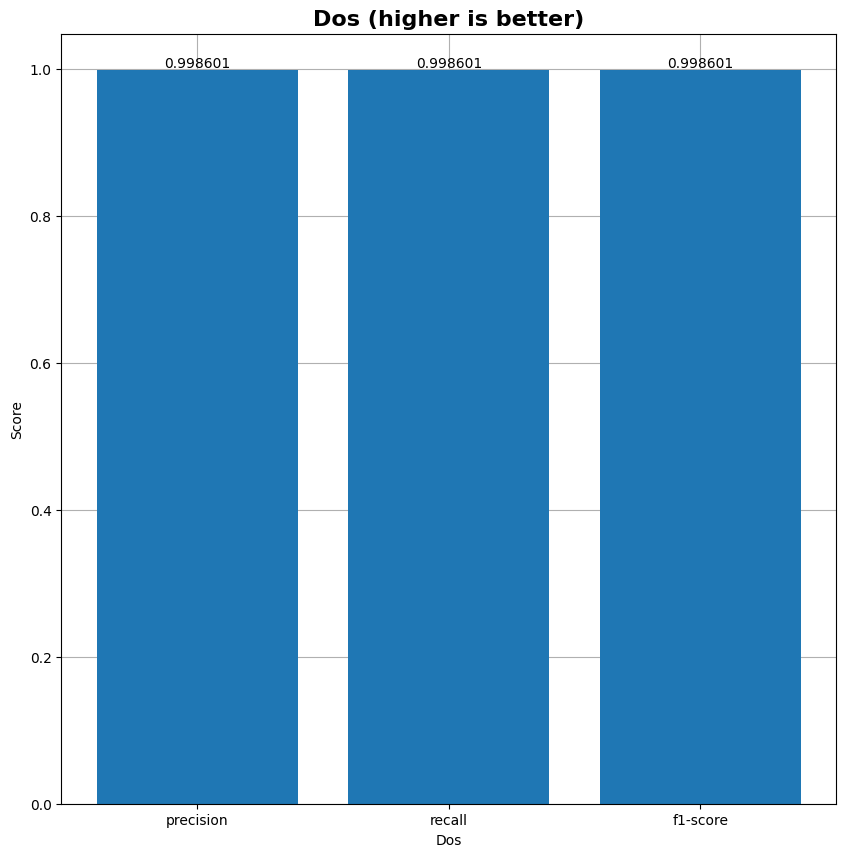

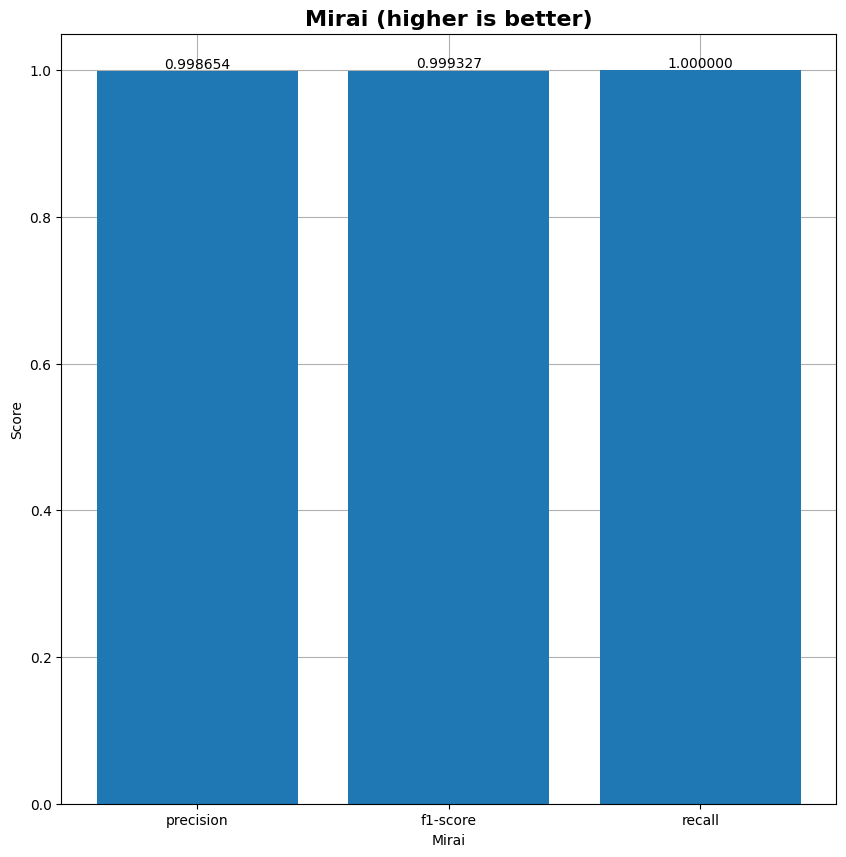

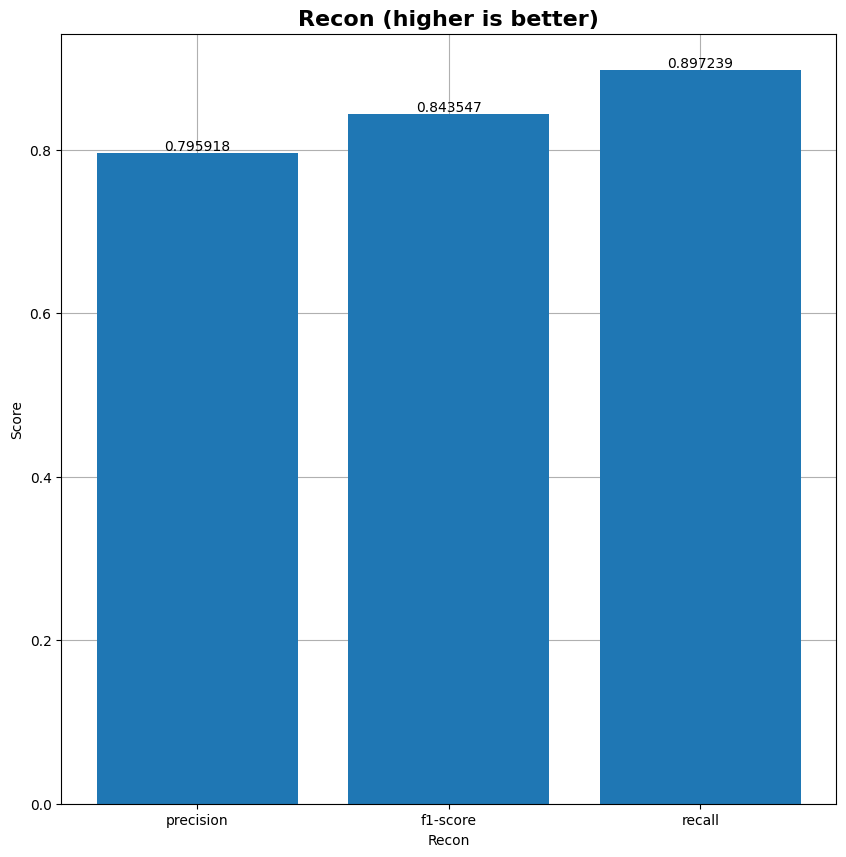

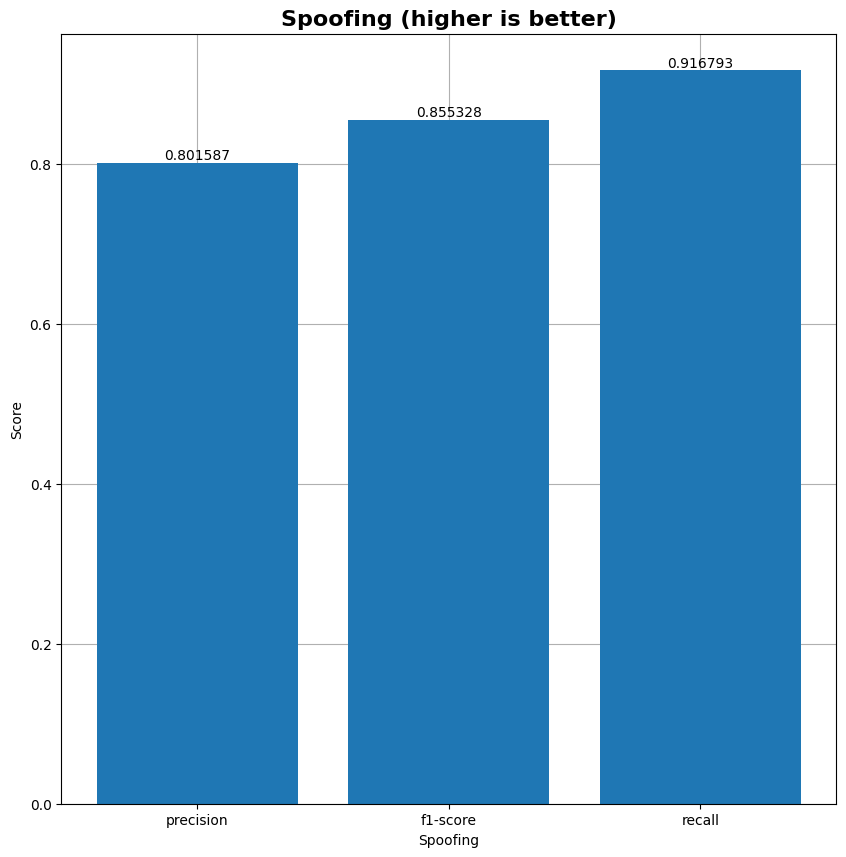

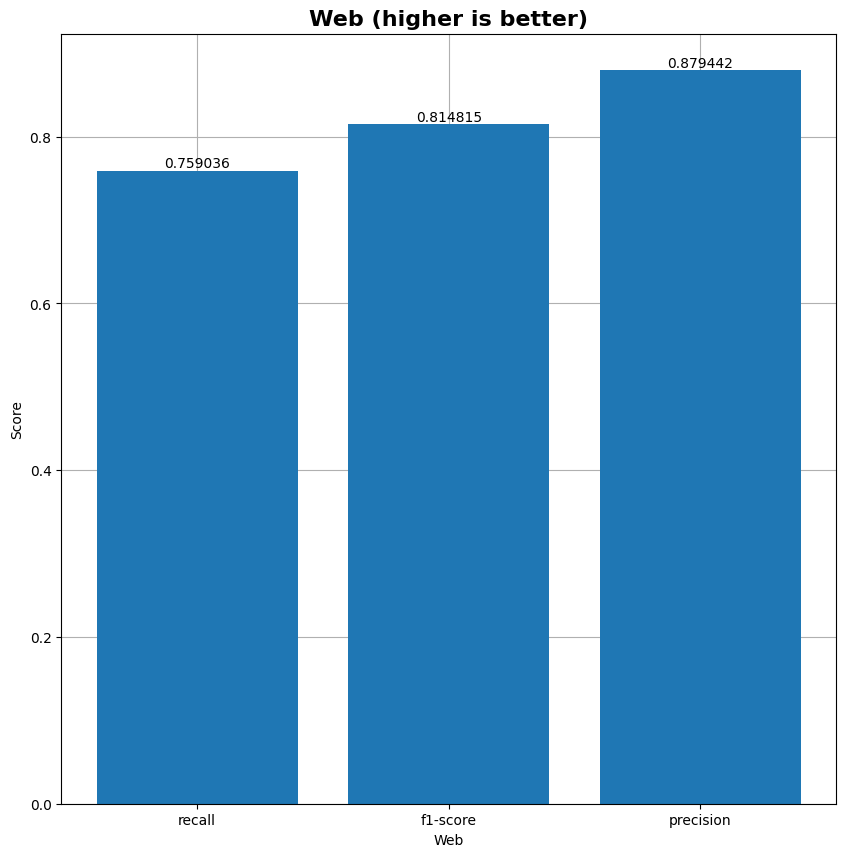

In [53]:
plot_mc(y_pred, y_test, "LightGBM")

In [54]:
model_name = "LightGBM_5000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [55]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

CPU times: user 2min 59s, sys: 527 ms, total: 3min
Wall time: 3min 1s


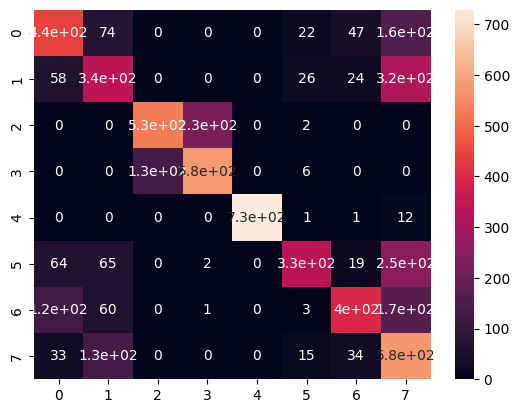

In [56]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [57]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [58]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, SVM_Time]
results_dict["SVM"] = results

In [59]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [60]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305
XGBoost,0.898667,0.901361,0.898907,0.898667,0.884487,0.402167,2.066500,1.437533,1.928581
LightGBM,0.901833,0.905553,0.902174,0.901833,0.888248,0.388333,1.987333,1.409728,1.693437
SVM,0.653833,0.697194,0.658582,0.653833,0.610519,1.258833,6.520167,2.553462,181.247970


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.597841    0.446335  0.695251  0.806993  0.981157  0.454422   
recall     0.612725    0.508197  0.799697  0.713226  1.000000  0.816626   
f1-score   0.605191    0.475261  0.743825  0.757218  0.990489  0.583916   

           Spoofing       Web  
precision  0.525132  0.729695  
recall     0.760536  0.389039  
f1-score   0.621283  0.507502  


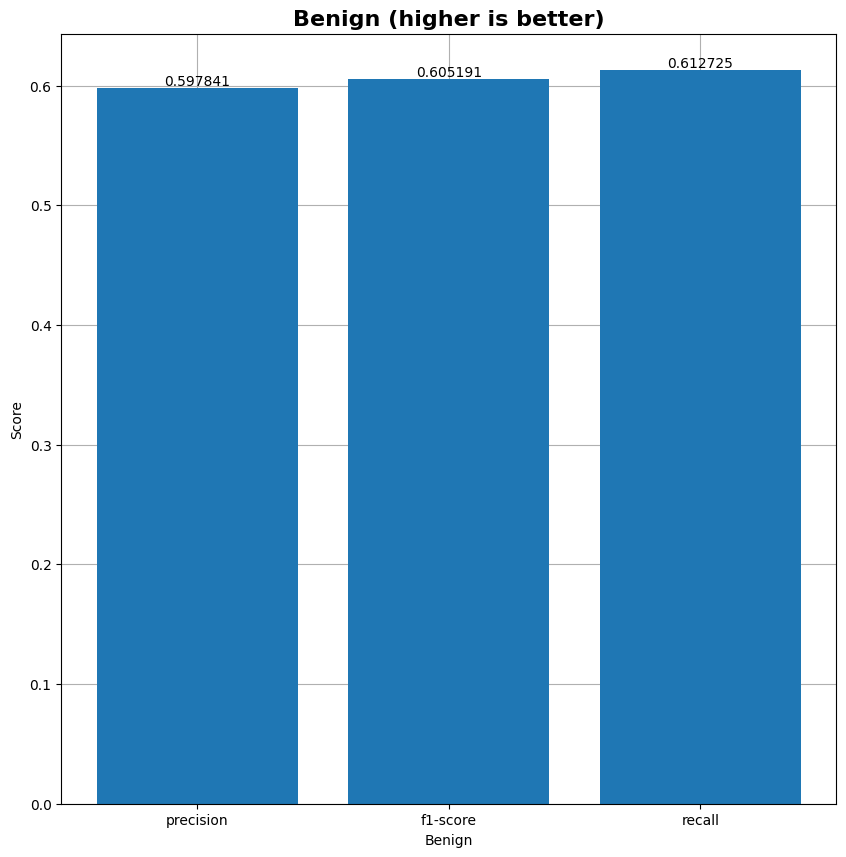

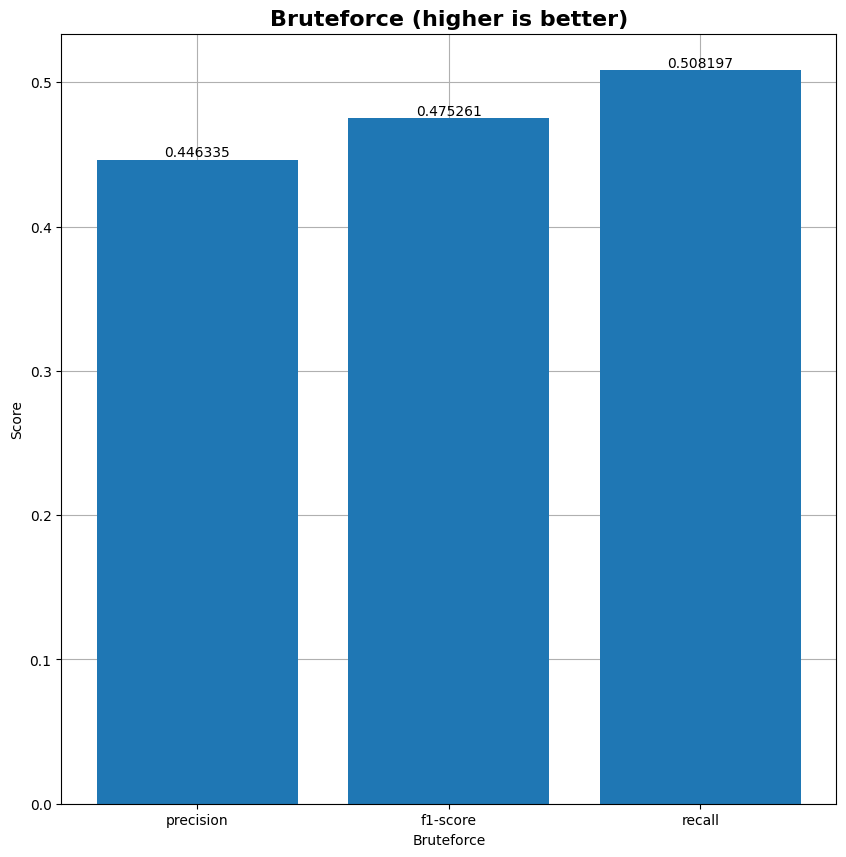

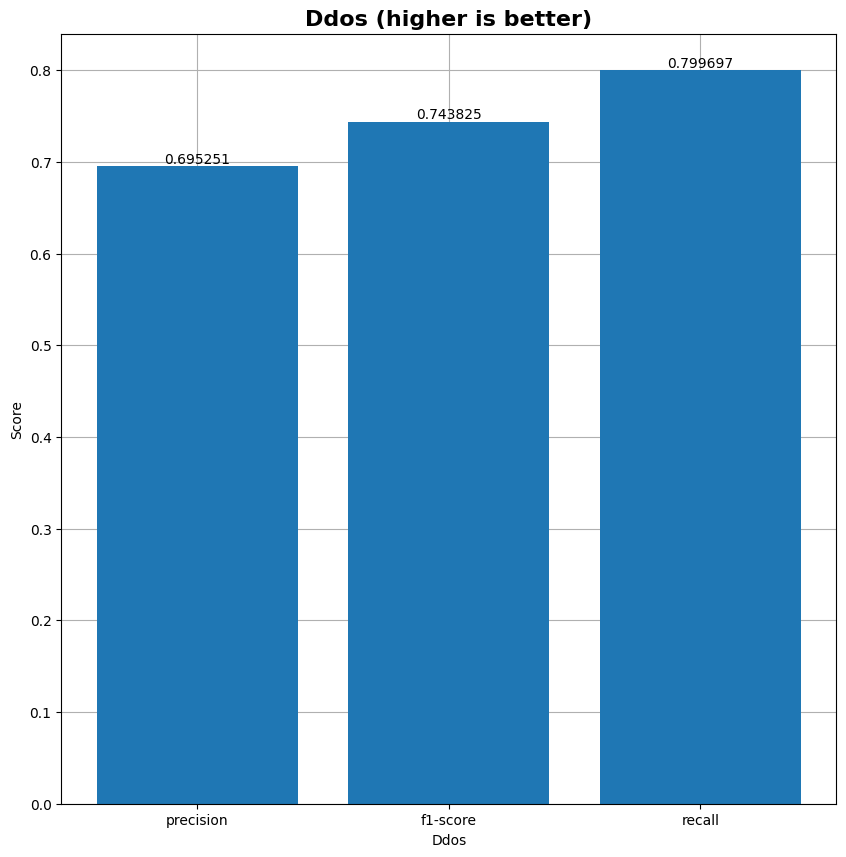

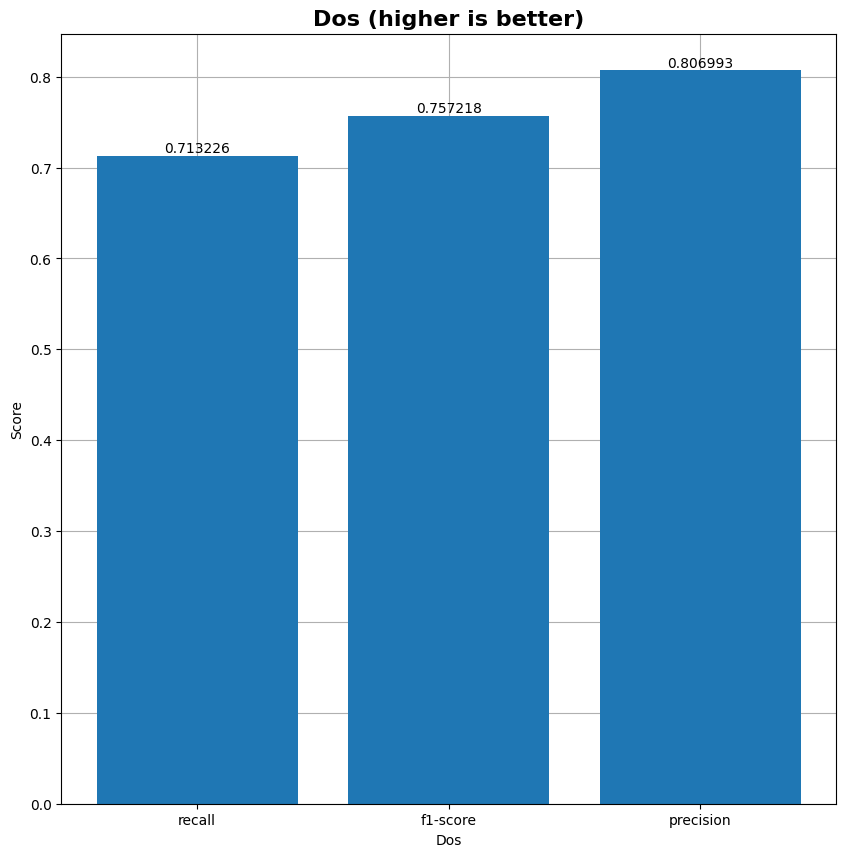

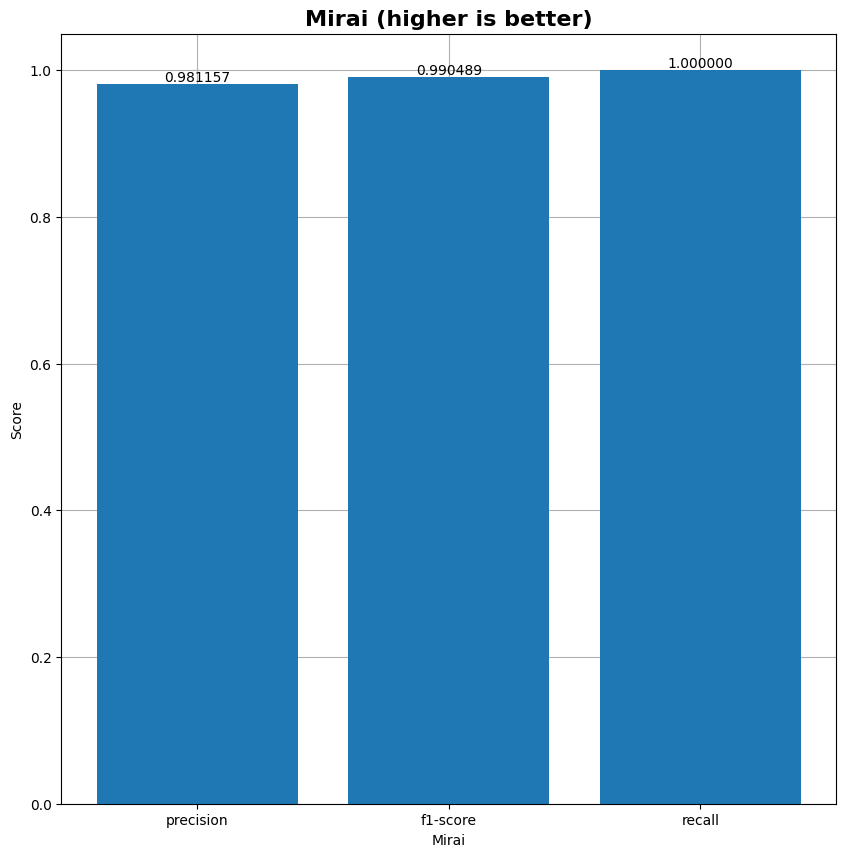

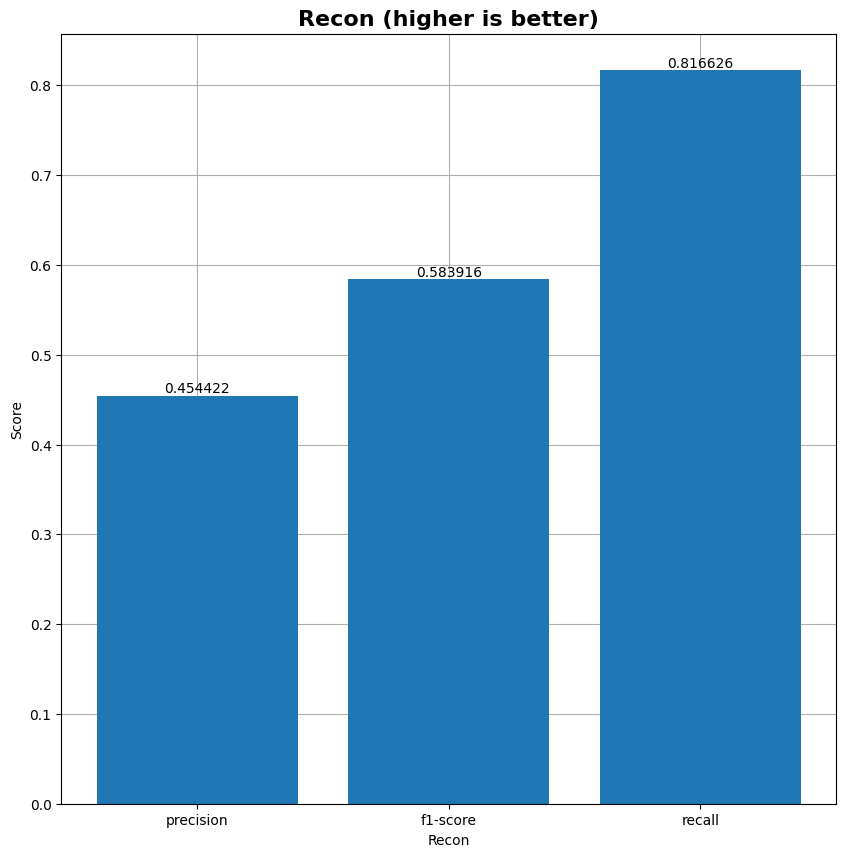

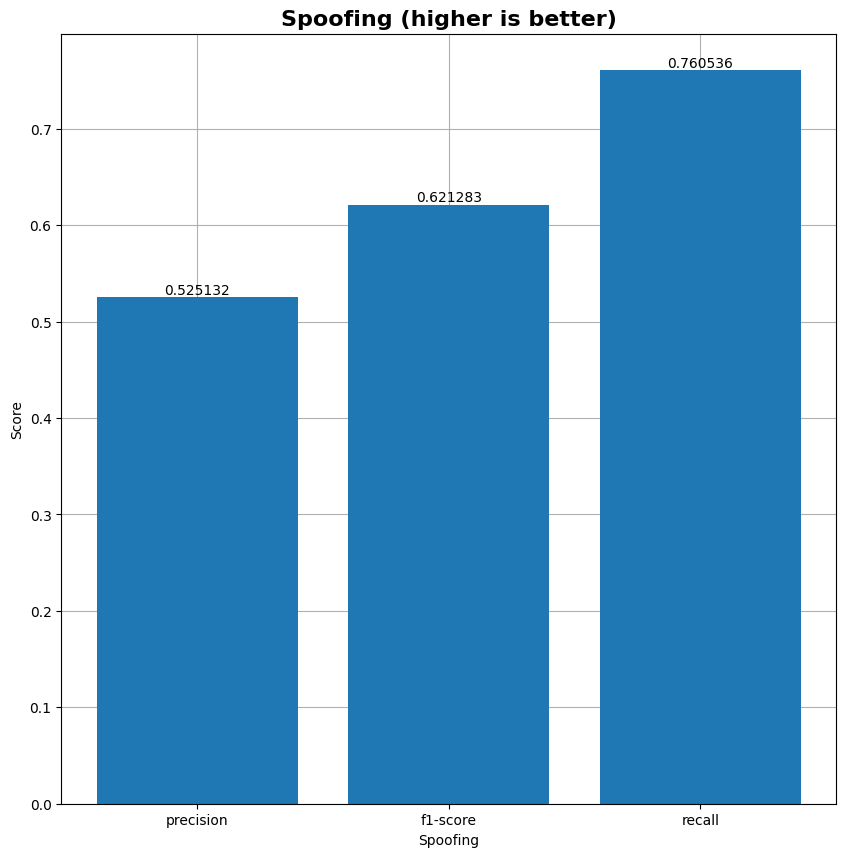

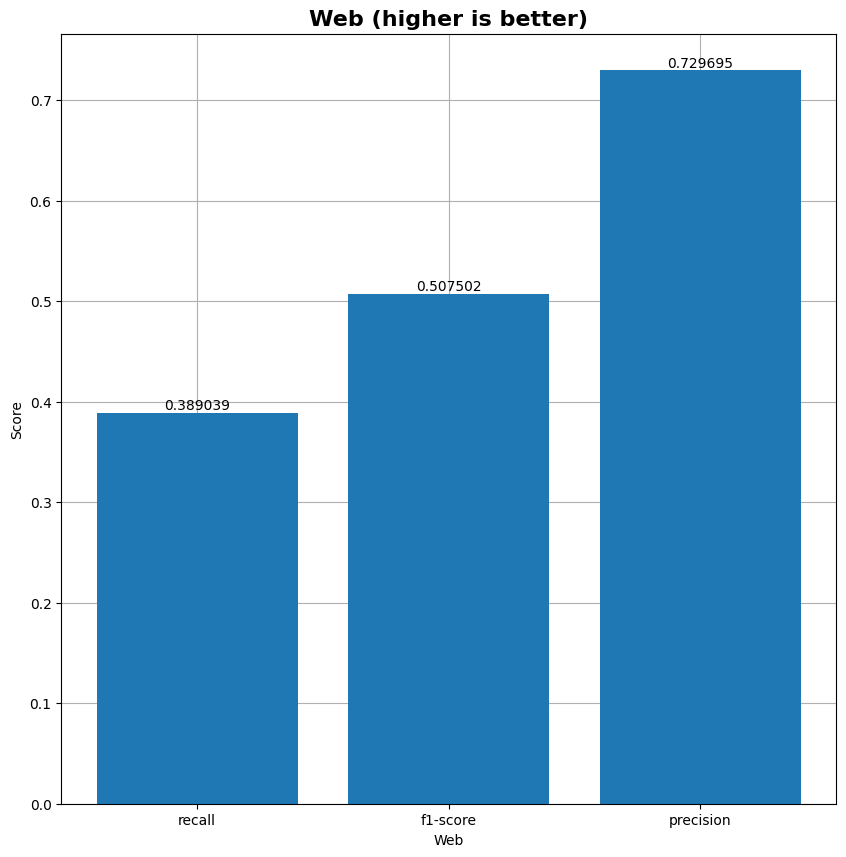

In [61]:
plot_mc(y_pred, y_test, "SVM")

In [62]:
model_name = "SVM_5000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27880, 46), (27880,), (6120, 46), (6120,), (6000, 46), (6000,))

In [64]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744572034.566161  288607 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5302 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744572035.930302  294341 service.cc:152] XLA service 0x769280008ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744572035.930317  294341 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-13 22:20:35.952351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744572036.094463  294341 cuda_dnn.cc:529] Loaded cuDNN version 90300


  82/1743 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4176 - loss: 1.5578  

I0000 00:00:1744572036.883882  294341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1743/1743 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5929 - loss: 0.9938 - val_accuracy: 0.6804 - val_loss: 0.7912
Epoch 2/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6774 - loss: 0.7719 - val_accuracy: 0.6962 - val_loss: 0.7458
Epoch 3/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6958 - loss: 0.7254 - val_accuracy: 0.7028 - val_loss: 0.7207
Epoch 4/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7081 - loss: 0.6975 - val_accuracy: 0.7052 - val_loss: 0.7291
Epoch 5/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7138 - loss: 0.6796 - val_accuracy: 0.6987 - val_loss: 0.7147
Epoch 6/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7228 - loss: 0.6615 - val_accuracy: 0.6891 - val_loss: 0.7151
Epoch 7/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7206 - loss: 0.6568 - val_accuracy: 0.7196 - val_loss: 0.6919
Epoch 8/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7325 - loss: 0.6460 - val_accurac

In [67]:
y_pred = np.argmax(y_pred, axis=1)

In [68]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7318 - loss: 0.7908   


In [69]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [70]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [71]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305
XGBoost,0.898667,0.901361,0.898907,0.898667,0.884487,0.402167,2.066500,1.437533,1.928581
LightGBM,0.901833,0.905553,0.902174,0.901833,0.888248,0.388333,1.987333,1.409728,1.693437
SVM,0.653833,0.697194,0.658582,0.653833,0.610519,1.258833,6.520167,2.553462,181.247970
FF-NN,0.727833,0.742792,0.729447,0.727833,0.690749,0.924500,4.468500,2.113883,80.404537


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.677719    0.676512  0.712780  0.865870  0.998737  0.591678   
recall     0.699042    0.545351  0.850629  0.749425  0.997478  0.683183   
f1-score   0.688215    0.603892  0.775627  0.803450  0.998107  0.634146   

           Spoofing       Web  
precision  0.594629  0.692647  
recall     0.821555  0.550234  
f1-score   0.689911  0.613281  


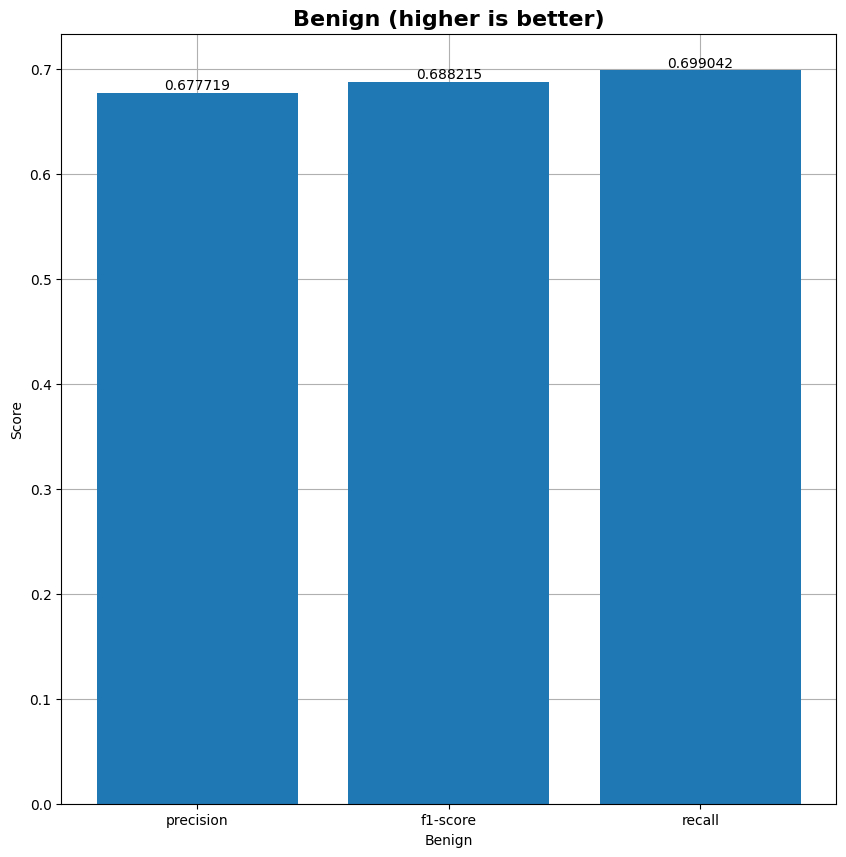

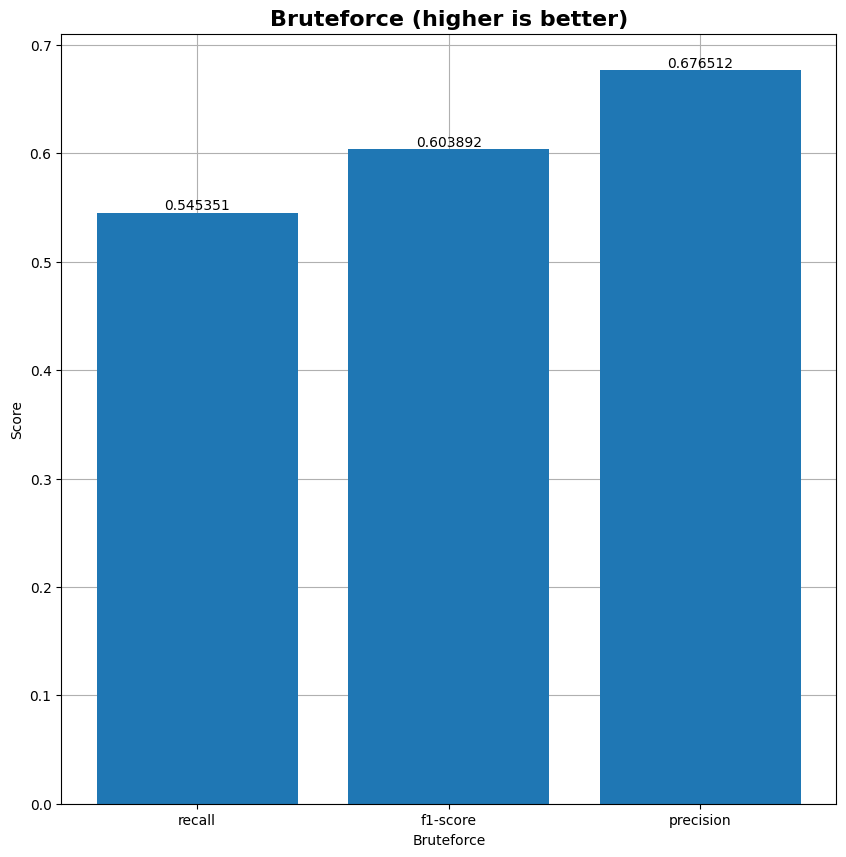

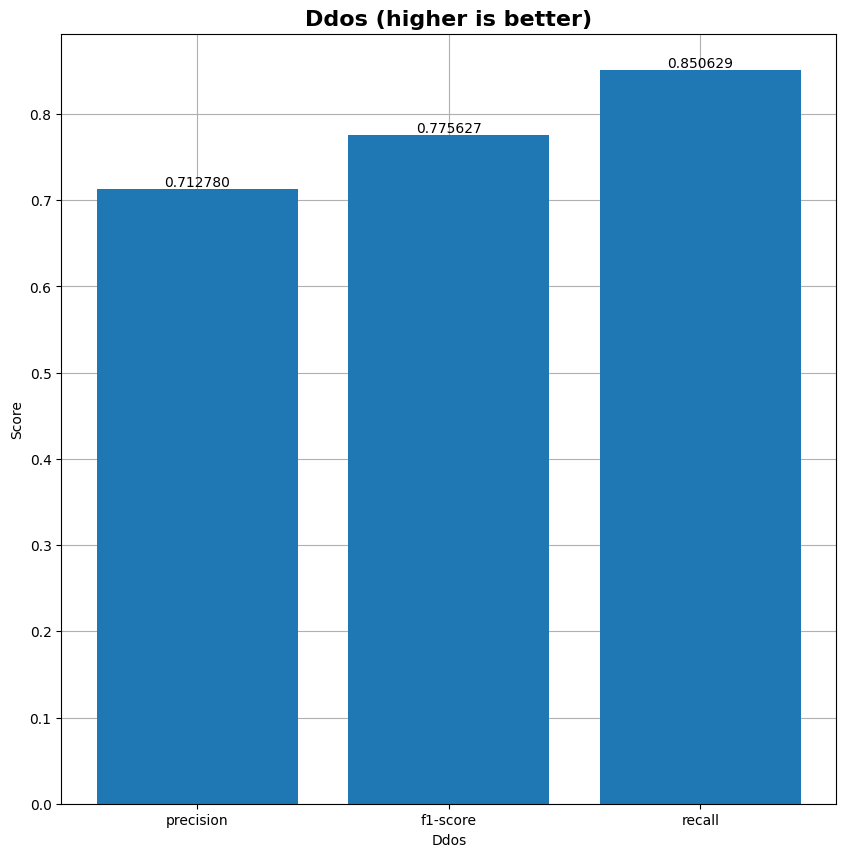

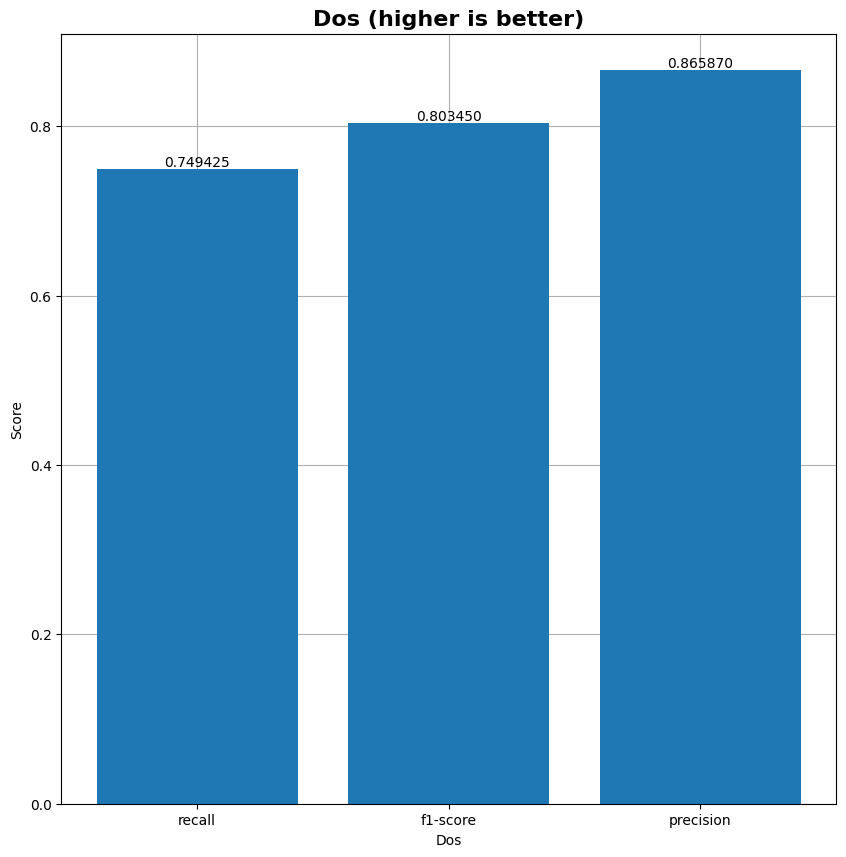

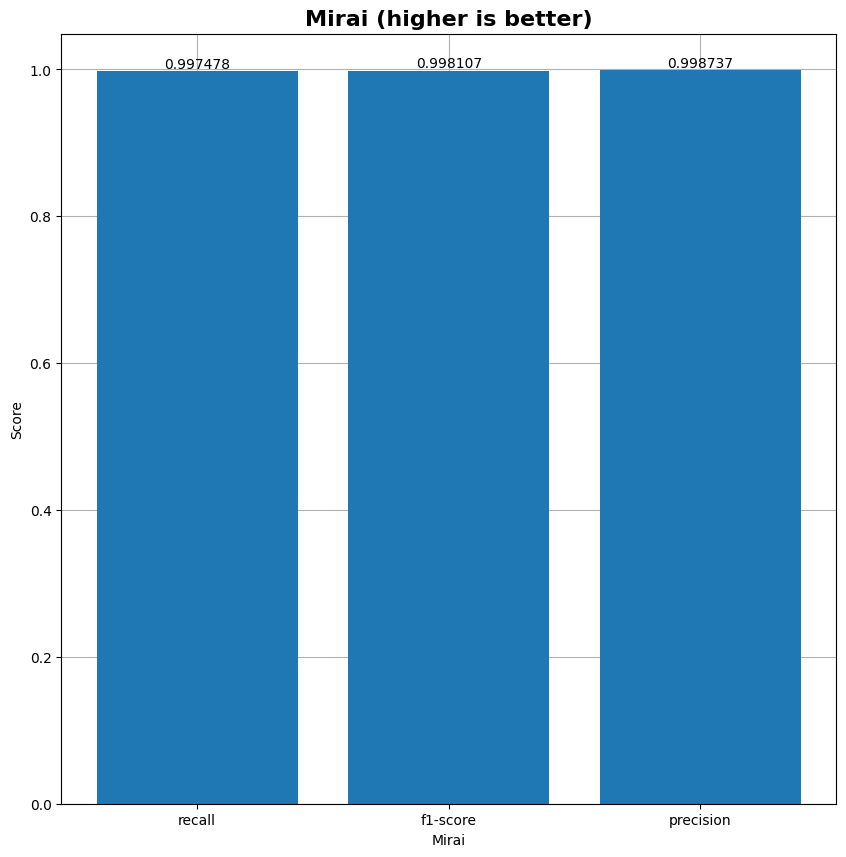

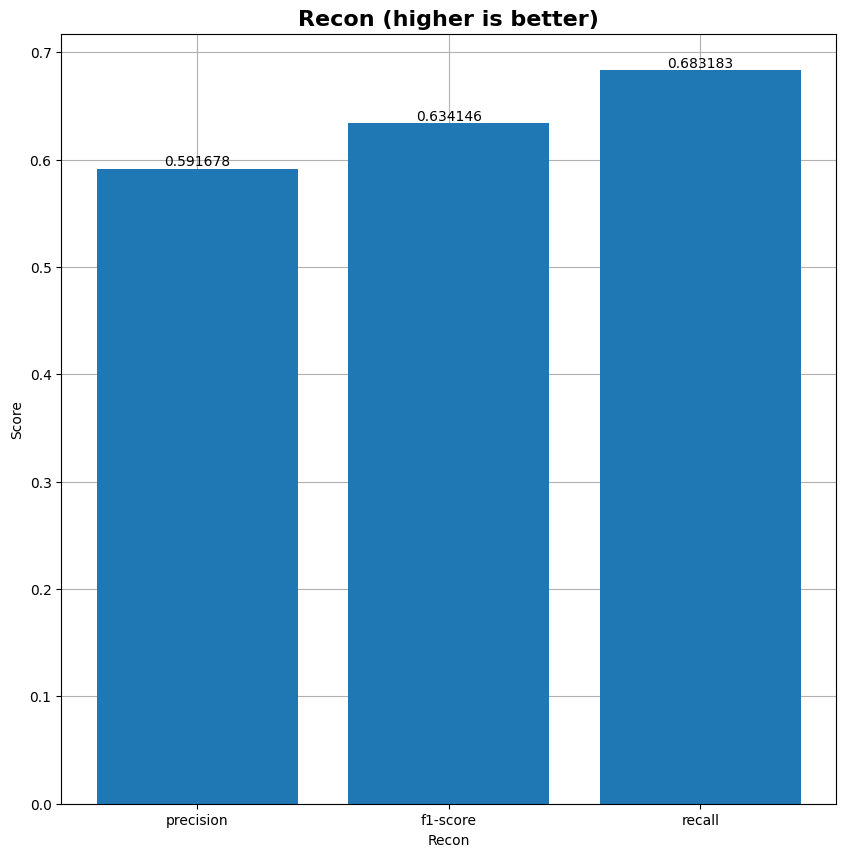

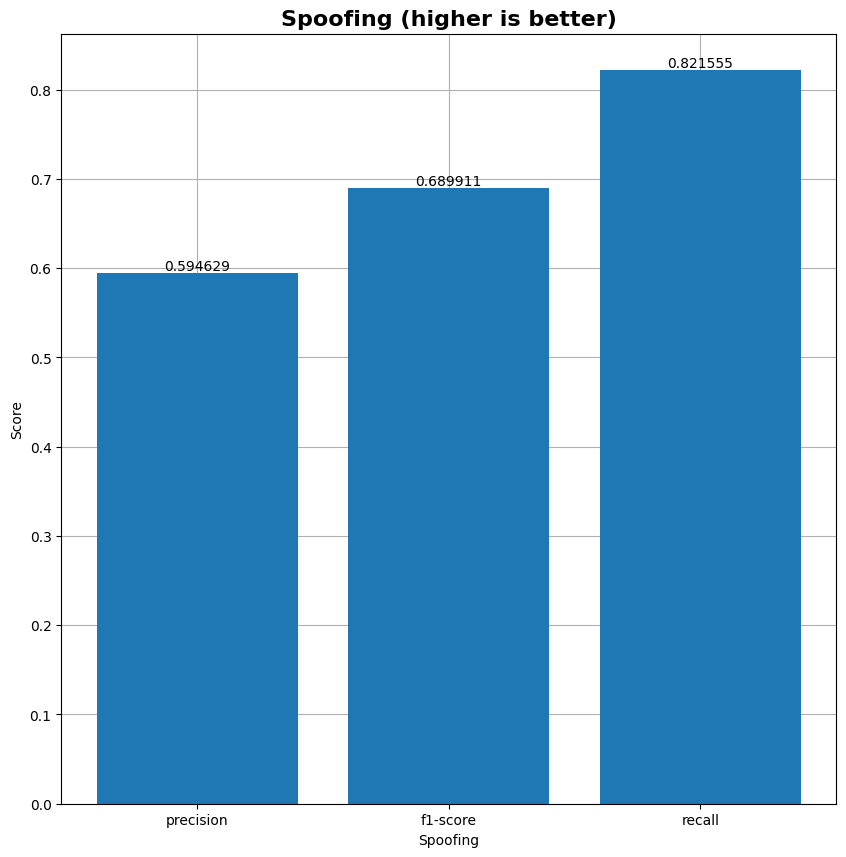

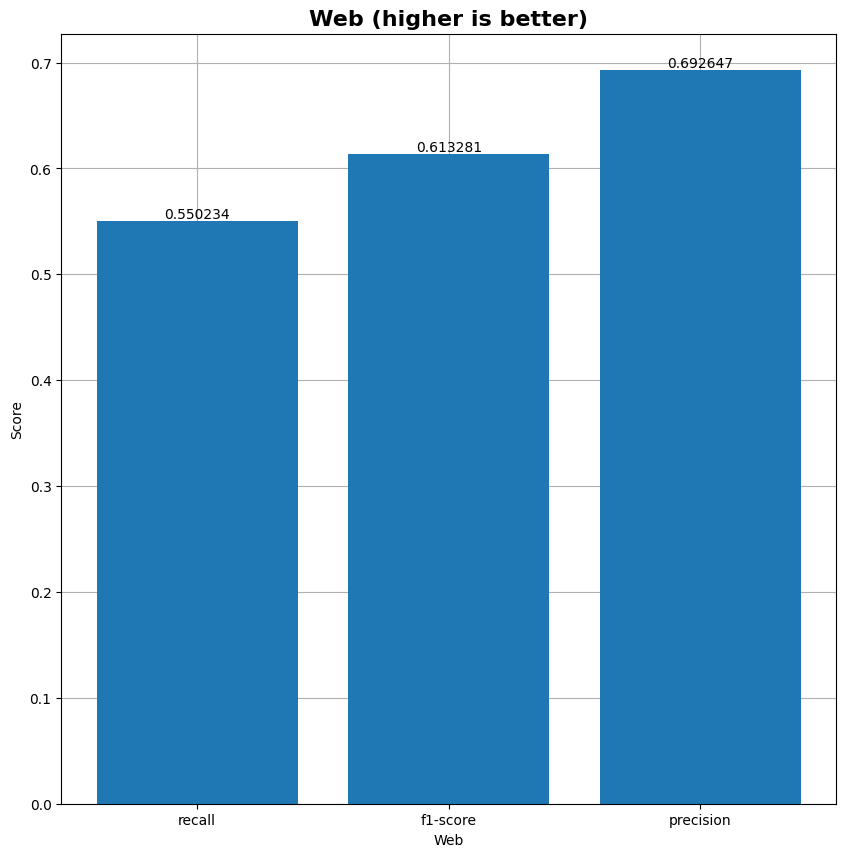

In [72]:
plot_mc(y_pred, y_test, "FF-NN")

In [73]:
model_name = "FFNN_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [74]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [75]:
num_components = len(np.unique(y))

In [76]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [77]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [78]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [79]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9120 - loss: 0.4054 - val_accuracy: 0.9960 - val_loss: 0.0144
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9959 - loss: 0.0195 - val_accuracy: 0.9968 - val_loss: 0.0137
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9968 - loss: 0.0146 - val_accuracy: 0.9985 - val_loss: 0.0080
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9952 - val_loss: 0.0227
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9975 - loss: 0.0116 - val_accuracy: 0.9982 - val_loss: 0.0072
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.

In [82]:
_, accuracy = model.evaluate(X_test, y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0043     


In [83]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [84]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [85]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [86]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [87]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.696500,0.701881,0.697061,0.696500,0.653815,1.171667,6.063667,2.462451,0.292083
LR,0.644833,0.660977,0.645599,0.644833,0.595884,1.250167,6.189167,2.487804,126.027263
RF,0.880167,0.884221,0.880294,0.880167,0.863571,0.457833,2.312167,1.520581,1.608305
XGBoost,0.898667,0.901361,0.898907,0.898667,0.884487,0.402167,2.066500,1.437533,1.928581
LightGBM,0.901833,0.905553,0.902174,0.901833,0.888248,0.388333,1.987333,1.409728,1.693437
SVM,0.653833,0.697194,0.658582,0.653833,0.610519,1.258833,6.520167,2.553462,181.247970
FF-NN,0.727833,0.742792,0.729447,0.727833,0.690749,0.924500,4.468500,2.113883,80.404537
LSTM,0.998999,0.999004,0.999000,0.998999,0.998857,0.004169,0.021511,0.146665,59.185681


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.998645    0.996207  1.000000  0.998715  1.000000  0.998661   
recall     1.000000    1.000000  0.998628  1.000000  0.998605  1.000000   
f1-score   0.999322    0.998100  0.999314  0.999357  0.999302  0.999330   

           Spoofing       Web  
precision       1.0  1.000000  
recall          1.0  0.994638  
f1-score        1.0  0.997312  


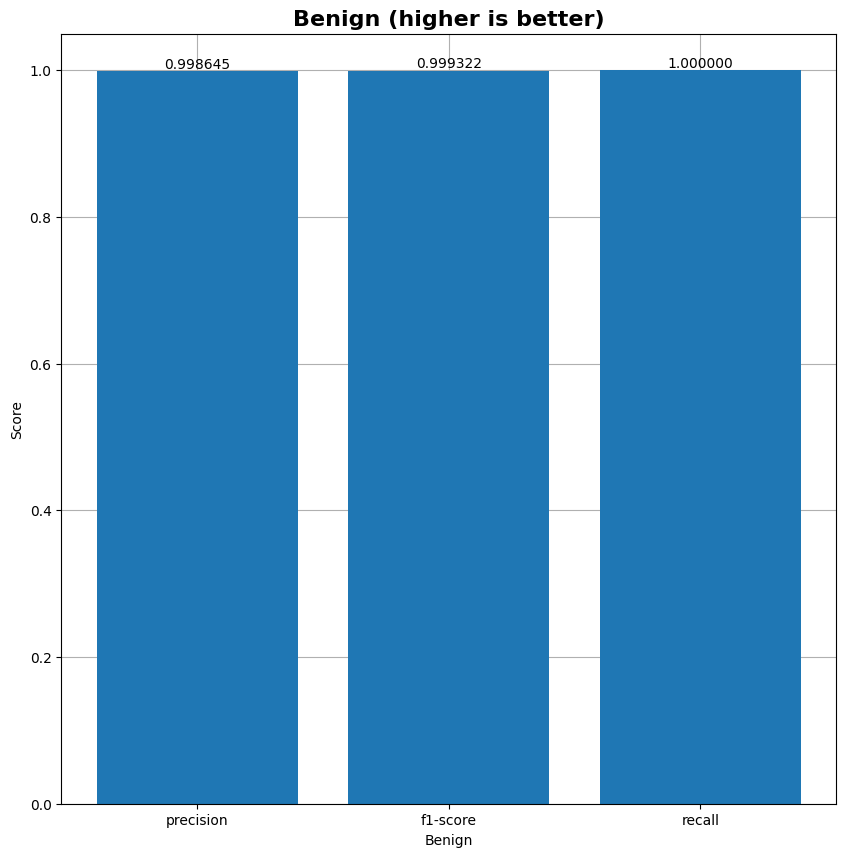

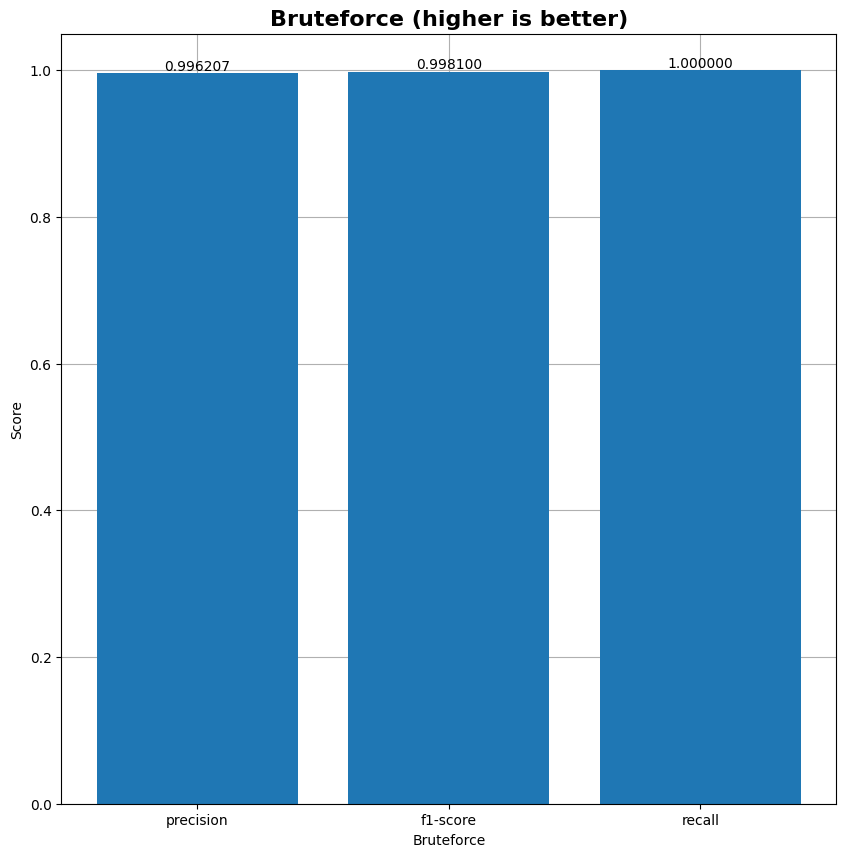

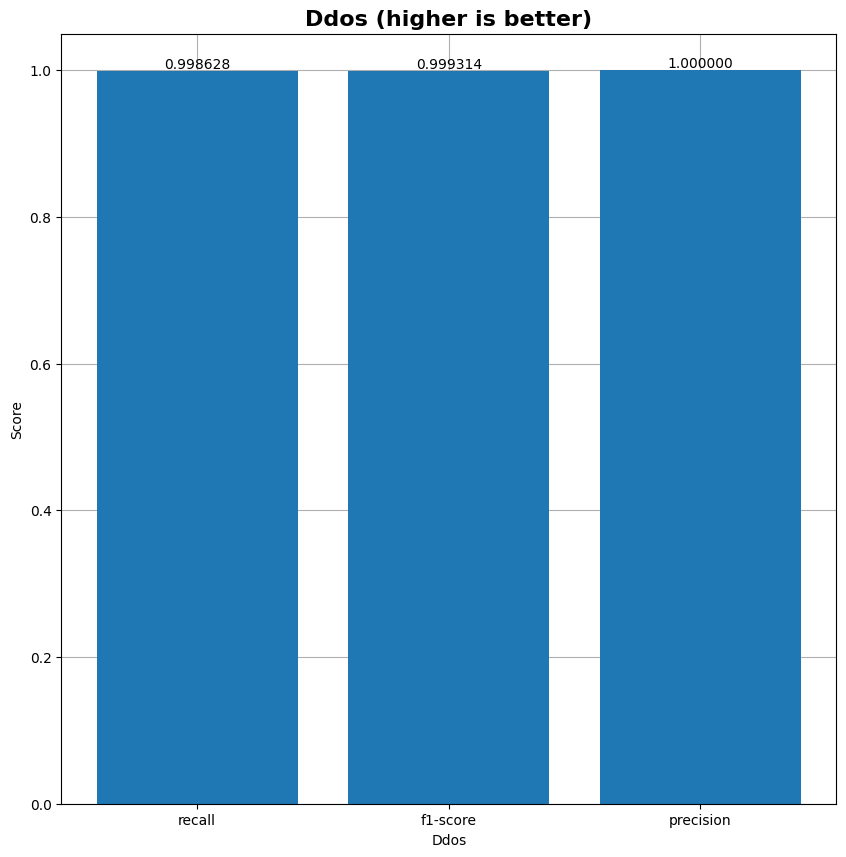

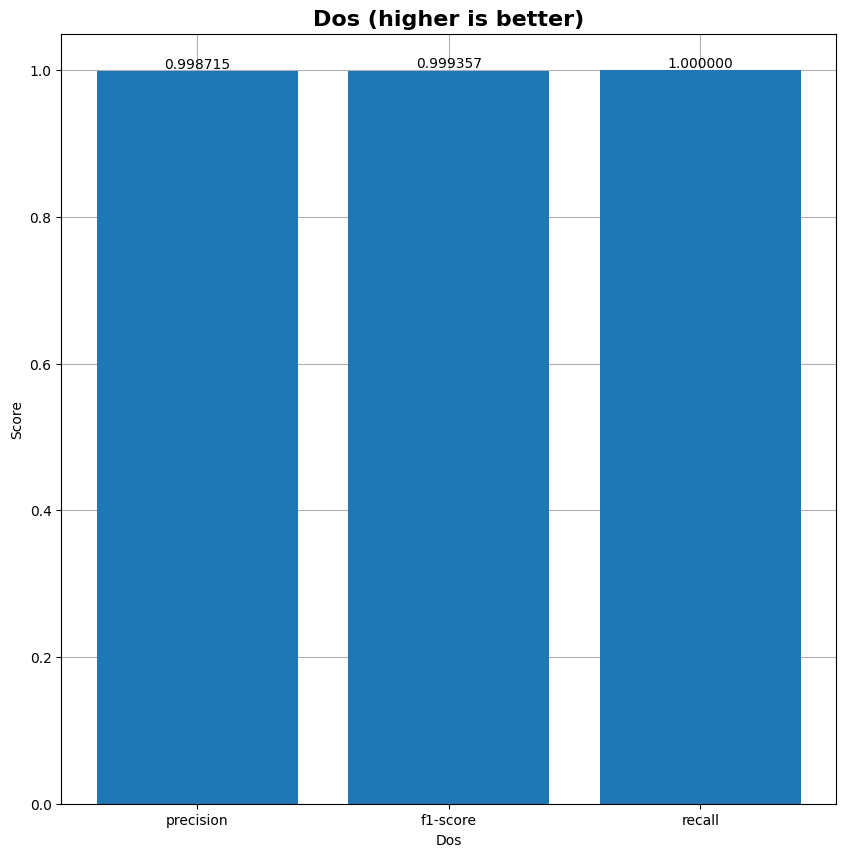

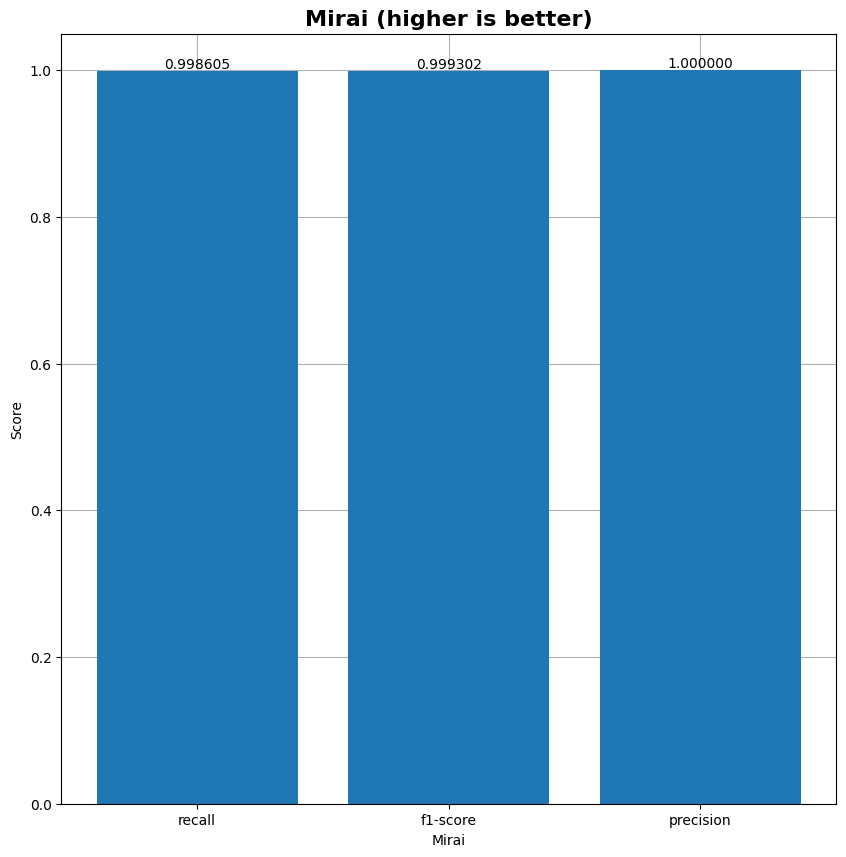

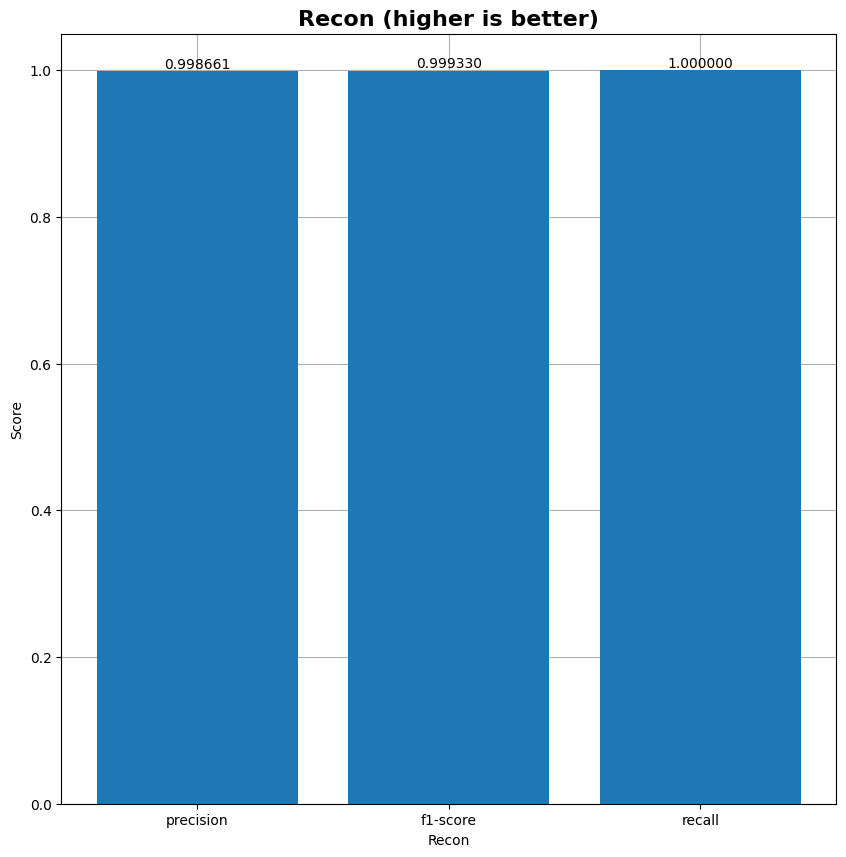

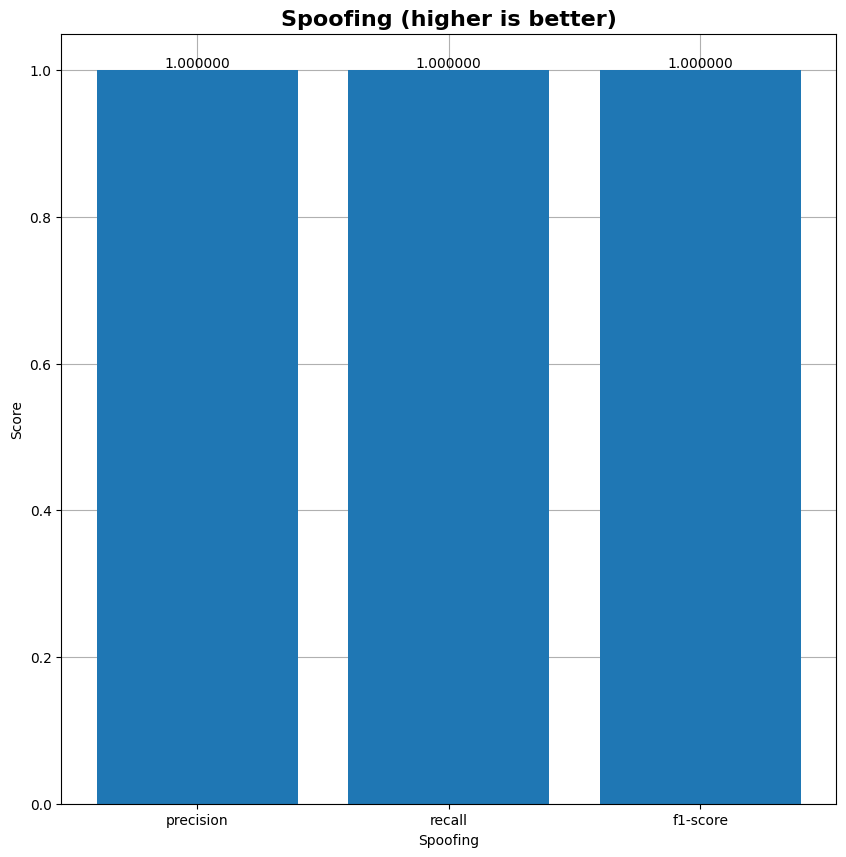

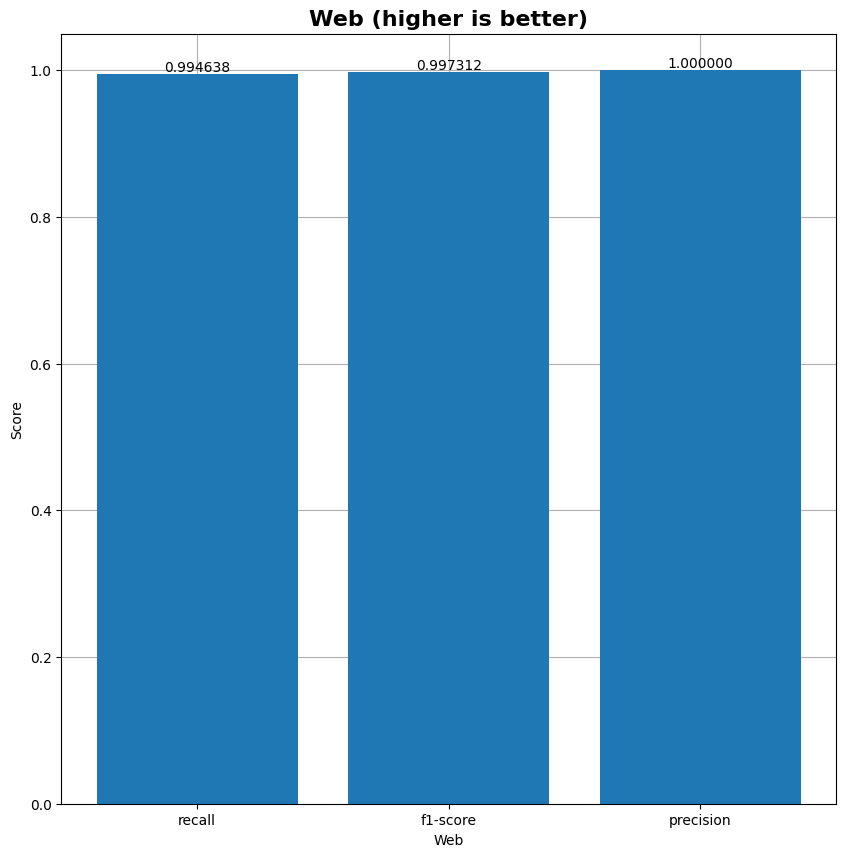

In [88]:
plot_mc(y_pred, y_test, "LSTM")

In [89]:
model_name = "LSTM_5000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

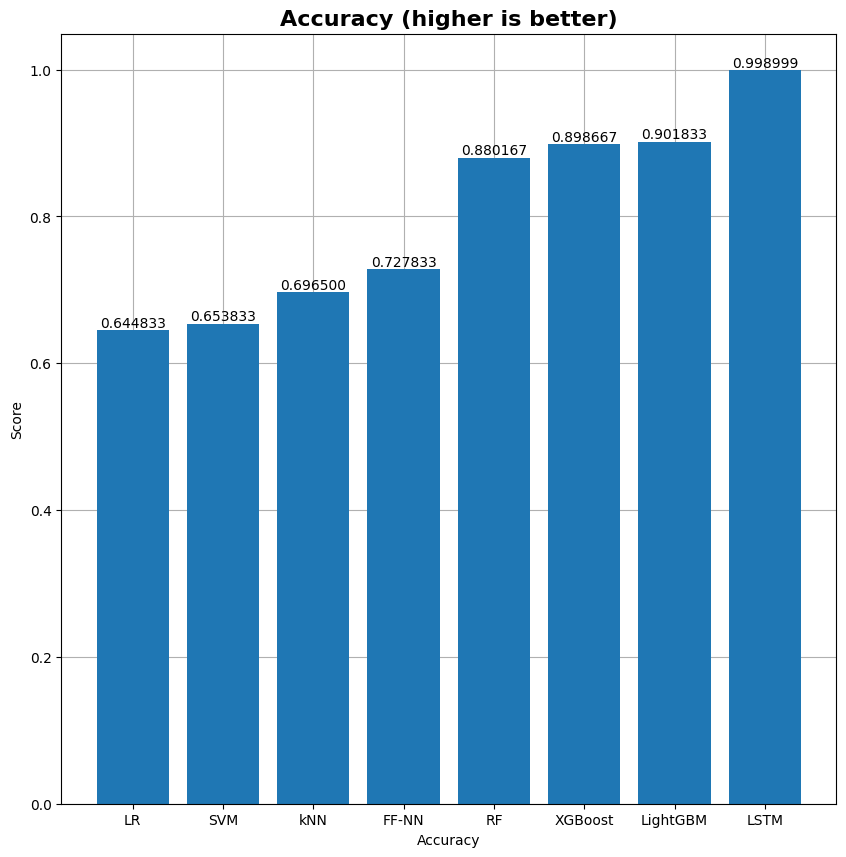

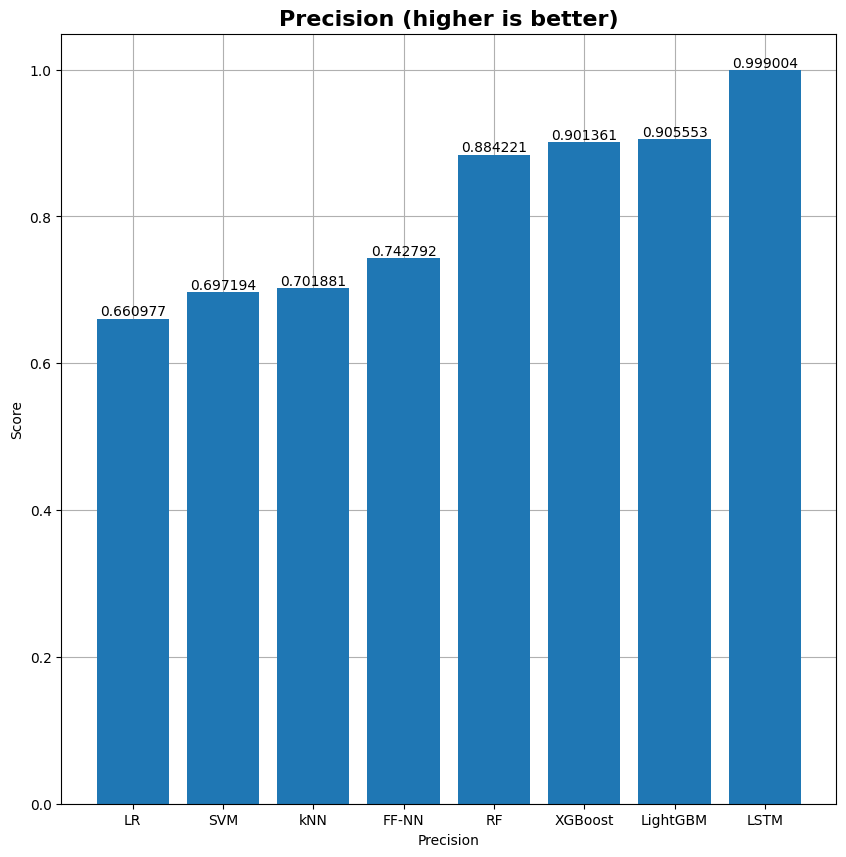

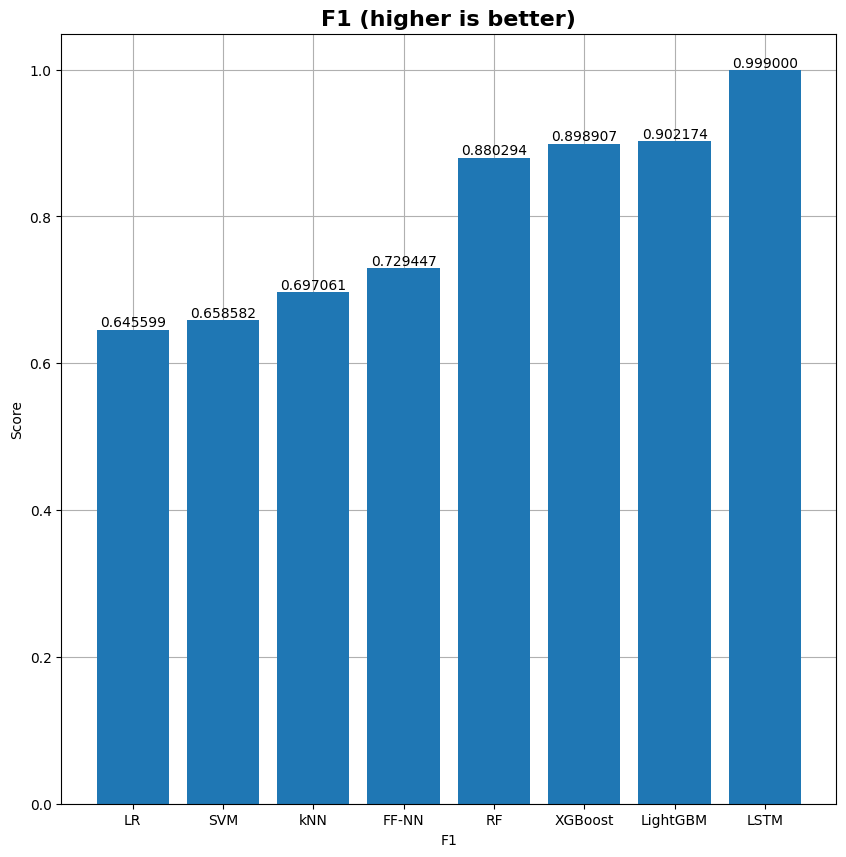

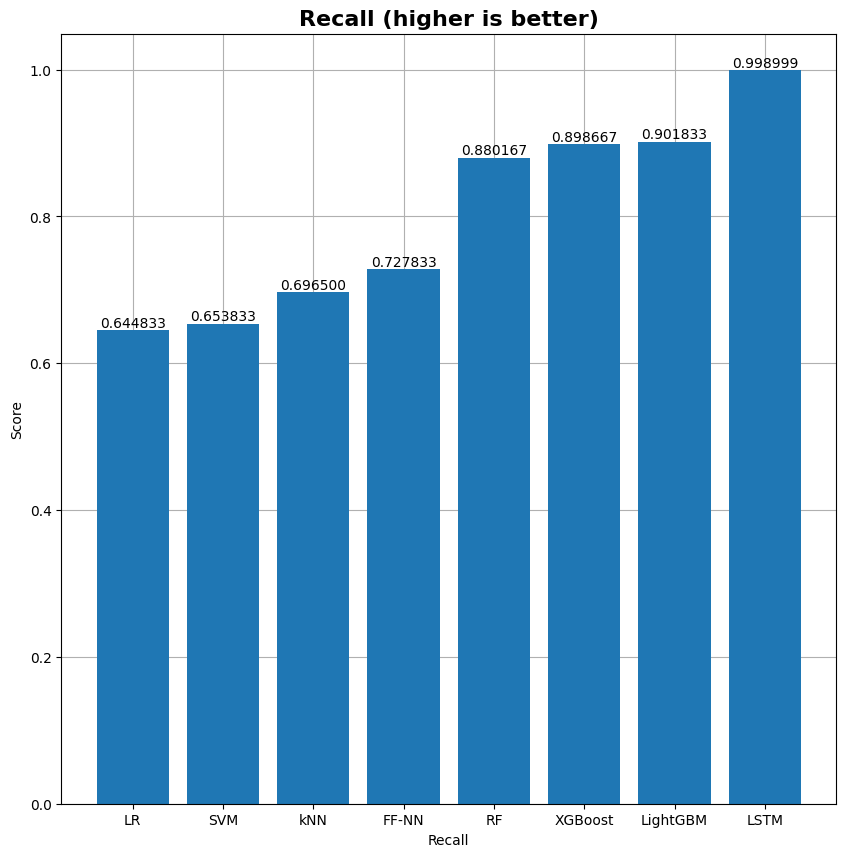

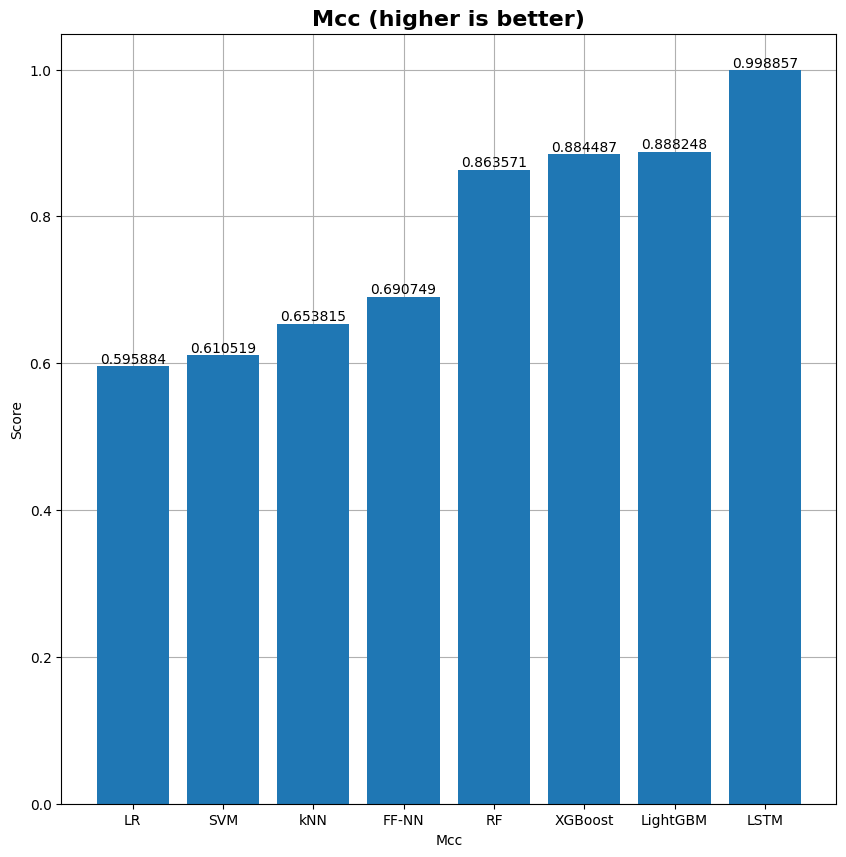

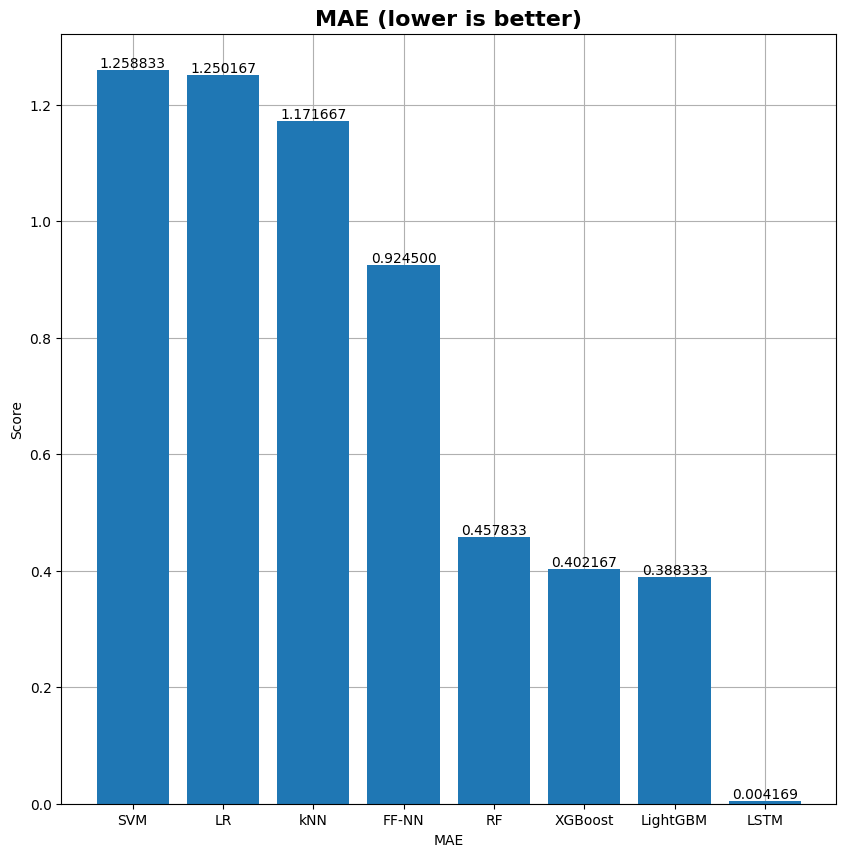

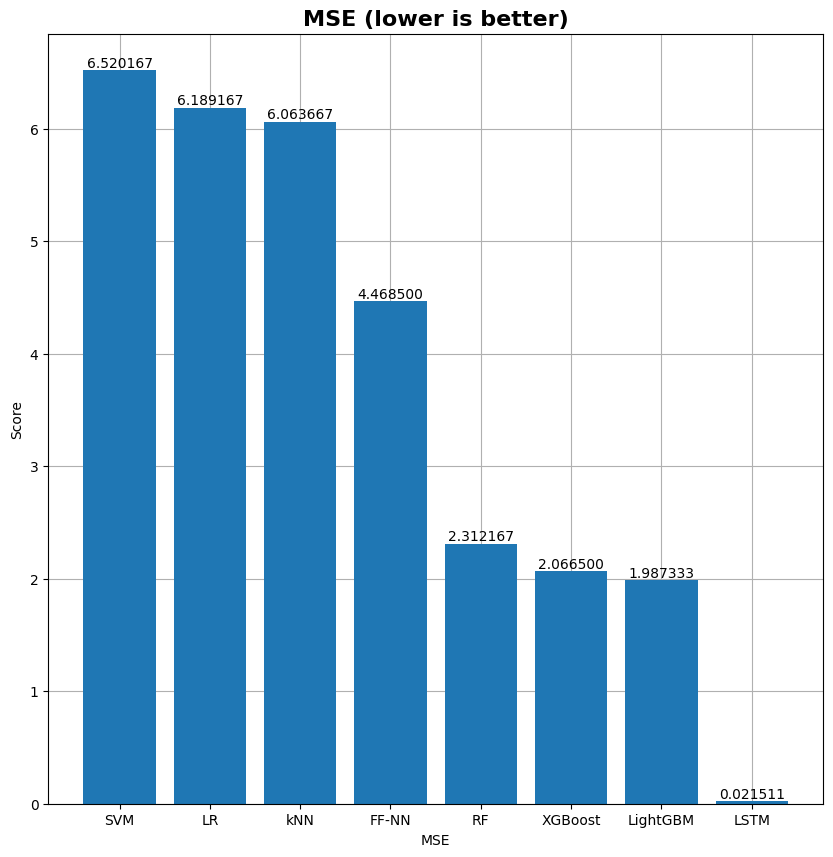

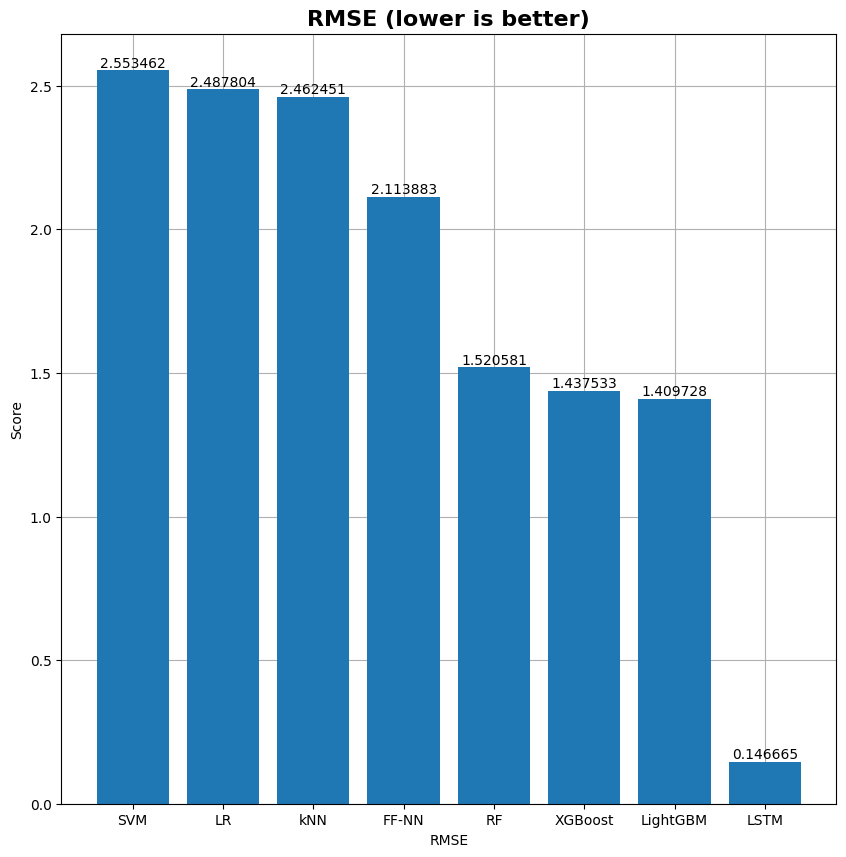

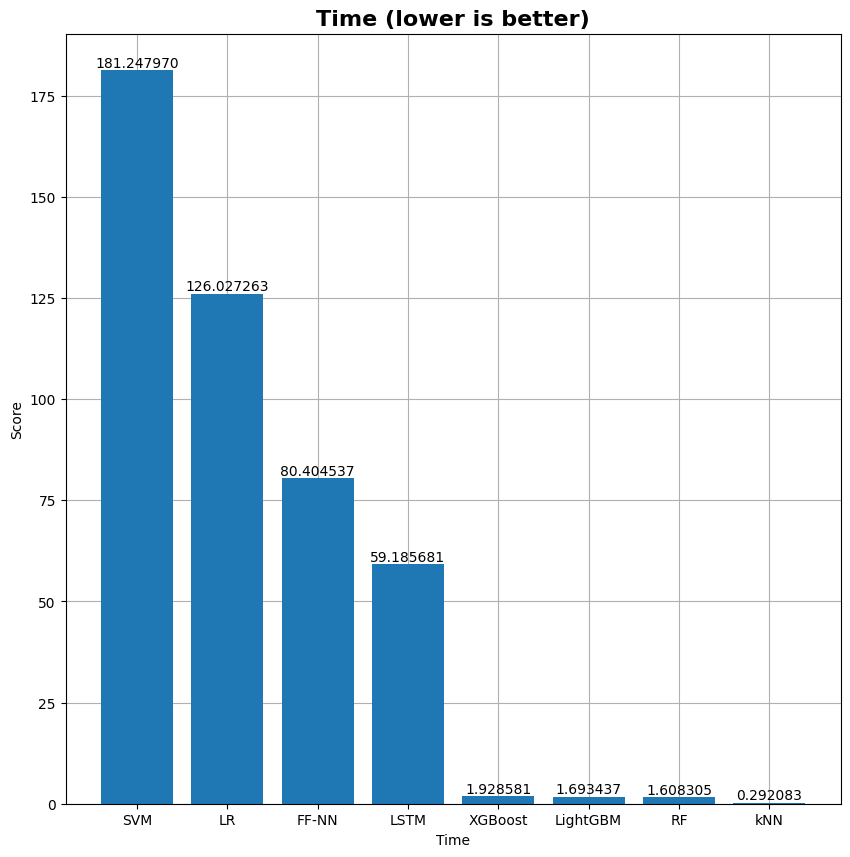

In [90]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [91]:
results_df.to_dict()

{'Accuracy': {'kNN': 0.6965,
  'LR': 0.6448333333333334,
  'RF': 0.8801666666666667,
  'XGBoost': 0.8986666666666666,
  'LightGBM': 0.9018333333333334,
  'SVM': 0.6538333333333334,
  'FF-NN': 0.7278333306312561,
  'LSTM': 0.9989994764328003},
 'Precision': {'kNN': 0.7018813237807254,
  'LR': 0.6609774645752197,
  'RF': 0.8842207047150085,
  'XGBoost': 0.9013605959368484,
  'LightGBM': 0.9055529501291061,
  'SVM': 0.6971944201539112,
  'FF-NN': 0.7427920953390976,
  'LSTM': 0.9990035374626366},
 'F1': {'kNN': 0.6970613146215435,
  'LR': 0.6455987391848781,
  'RF': 0.8802944695003072,
  'XGBoost': 0.8989065464658794,
  'LightGBM': 0.9021738956537871,
  'SVM': 0.6585816826406794,
  'FF-NN': 0.7294470092178599,
  'LSTM': 0.998999870452842},
 'Recall': {'kNN': 0.6965,
  'LR': 0.6448333333333334,
  'RF': 0.8801666666666667,
  'XGBoost': 0.8986666666666666,
  'LightGBM': 0.9018333333333334,
  'SVM': 0.6538333333333334,
  'FF-NN': 0.7278333333333333,
  'LSTM': 0.9989994997498749},
 'MCC': {'kN